In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("/content/AswanData_weatherdata.csv")

# Weather Dataset Project — Solar(PV) Classification

**Dataset:** `AswanData_weatherdata.csv`  
**Goal:** Create a classification target from `Solar(PV)` (Low / Medium / High) and perform full preprocessing, EDA, feature-reduction (PCA, LDA), multiple classifiers (Naive Bayes, Bayesian Network if available, Decision Tree, LDA classifier, PCA+KNN, KNN with different distances), and evaluation (confusion matrix, accuracy, precision, recall, F1, ROC).



In [5]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report)
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Attempt to import pgmpy for Bayesian Network (may not be installed)
have_pgmpy = False
try:
    import pgmpy
    from pgmpy.estimators import HillClimbSearch, BicScore
    from pgmpy.models import BayesianModel
    have_pgmpy = True
except Exception as e:
    have_pgmpy = False

print('pgmpy available:', have_pgmpy)

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')


pgmpy available: False


# **1 - Data Pre-Processing**

In [6]:
#Dataset size : (rows, columns)
print('Shape:', df.shape)

Shape: (398, 8)


In [7]:
#First 5 rows
df.head()

,Unnamed: 0,Date,AvgTemperture,AverageDew(point via humidity),Humidity,Wind,Pressure,Solar(PV)
0,0,4/1/2022,87.9,31.3,13.4,5.7,29.2,19.010857
1,2,4/3/2022,90.2,34.0,14.2,6.6,29.1,16.885714
2,3,4/4/2022,93.2,31.4,11.8,8.8,29.1,19.627429
3,4,4/5/2022,92.5,24.9,9.4,8.0,29.1,18.929429
4,5,4/6/2022,91.2,18.9,7.8,9.4,29.2,18.934000


In [8]:
# Quick column cleaning
df.columns = [c.strip().replace('\n',' ').replace('  ',' ') for c in df.columns]

# Friendly rename map (adjust if your dataset differs)
rename_map = {
    'AvgTemperture':'AvgTemperature',
    'AverageDew(point via humidity)':'AverageDew',
    'Solar(PV)':'Solar_PV'
}
df.rename(columns=rename_map, inplace=True)

# Parse Date column if exists
if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Drop unnamed index-like column if present
for c in df.columns:
    if str(c).lower().startswith('unnamed'):
        df.drop(columns=[c], inplace=True)

print('After rename and cleanup — columns:')
print(df.columns.tolist())
df.head()


After rename and cleanup — columns:
['Date', 'AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure', 'Solar_PV']


,Date,AvgTemperature,AverageDew,Humidity,Wind,Pressure,Solar_PV
0,2022-04-01,87.9,31.3,13.4,5.7,29.2,19.010857
1,2022-04-03,90.2,34.0,14.2,6.6,29.1,16.885714
2,2022-04-04,93.2,31.4,11.8,8.8,29.1,19.627429
3,2022-04-05,92.5,24.9,9.4,8.0,29.1,18.929429
4,2022-04-06,91.2,18.9,7.8,9.4,29.2,18.934000


In [9]:
# Missing values
missing = df.isnull().sum()
print("Missing values (non-zero):")
print(missing[missing>0])

# Drop duplicate rows if any
dup_count = df.duplicated().sum()
print('Duplicate rows:', dup_count)
if dup_count>0:
    df = df.drop_duplicates()

# Basic stats
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', num_cols)
df[num_cols].describe().T


Missing values (non-zero):
Series([], dtype: int64)
Duplicate rows: 28
Numeric columns: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure', 'Solar_PV']


,count,mean,std,min,25%,50%,75%,max
AvgTemperature,370.0,81.405676,13.961259,51.100000,69.725000,84.250000,93.9000,102.700000
AverageDew,370.0,37.460811,8.749325,15.300000,30.400000,38.200000,44.3000,63.900000
Humidity,370.0,23.753784,9.641380,7.400000,16.325000,21.200000,29.6000,47.700000
Wind,370.0,10.314865,2.454501,4.400000,8.500000,10.300000,12.1750,17.100000
Pressure,370.0,29.190135,0.141962,28.900000,29.100000,29.200000,29.3000,29.600000
Solar_PV,370.0,24.800943,7.598311,8.581429,18.038214,24.368714,32.2165,40.038857


--- Applying Linear Regression (predicting continuous Solar_PV) ---

== Linear Regression Performance ==
Mean Squared Error (MSE): 56.5232
Root Mean Squared Error (RMSE): 7.5182
Mean Absolute Error (MAE): 6.3772
R-squared (R2): 0.0369
R-squared is low, suggesting the model explains a small portion of the variance in Solar_PV.


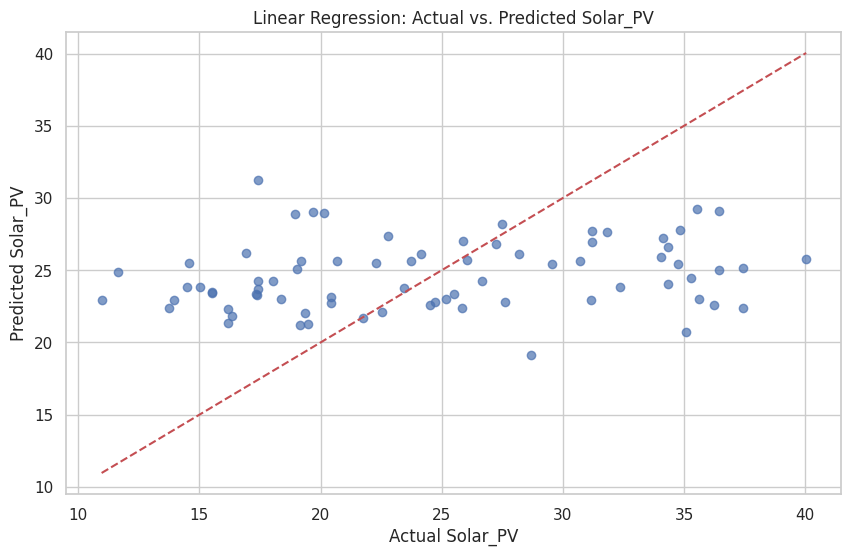

Linear Regression applied and evaluated successfully for continuous Solar_PV.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print('--- Applying Linear Regression (predicting continuous Solar_PV) ---')

# Prepare X and y for regression problem (using original Solar_PV as target)
# Ensure 'Month' is added if it was part of the classification features
features_for_regression = [c for c in num_cols if c != 'Solar_PV']

X_reg = df[features_for_regression].copy()
y_reg = df['Solar_PV'].copy()

# If 'Month' column was created, include it in X_reg if not already in num_cols
if 'Month' in df.columns and 'Month' not in features_for_regression:
    X_reg['Month'] = df['Month']

# Handle potential missing values in X_reg and y_reg (if any)
X_reg = X_reg.fillna(X_reg.median())
y_reg = y_reg.fillna(y_reg.mean())

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Scale features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Initialize Linear Regression model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_reg_scaled, y_train_reg)

# Make predictions
y_pred_reg = lin_reg.predict(X_test_reg_scaled)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"\n== Linear Regression Performance ==")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Interpretation of R-squared:
if r2 < 0:
    print("R-squared is negative, indicating the model performs worse than a horizontal line.")
elif r2 < 0.5:
    print("R-squared is low, suggesting the model explains a small portion of the variance in Solar_PV.")
else:
    print("R-squared is moderately high, indicating the model explains a significant portion of the variance in Solar_PV.")

# You can also visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Actual Solar_PV')
plt.ylabel('Predicted Solar_PV')
plt.title('Linear Regression: Actual vs. Predicted Solar_PV')
plt.grid(True)
plt.show()

print('Linear Regression applied and evaluated successfully for continuous Solar_PV.')

**Binning**

In [10]:
# Ensure Solar_PV exists
if 'Solar_PV' not in df.columns:
    raise ValueError('Solar_PV column not found — check your dataset column names')

# Use quantiles to define bins
q33 = df['Solar_PV'].quantile(0.33)
q66 = df['Solar_PV'].quantile(0.66)
print("33rd percentile:", q33, "66th percentile:", q66)

# Create labels
labels = ['Low', 'Medium', 'High']
df['Solar_cat'] = pd.cut(df['Solar_PV'], bins=[-np.inf, q33, q66, np.inf], labels=labels)

# Show counts
print(df['Solar_cat'].value_counts())


33rd percentile: 19.7108 66th percentile: 30.1755657166
Solar_cat
High      126
Low       122
Medium    122
Name: count, dtype: int64


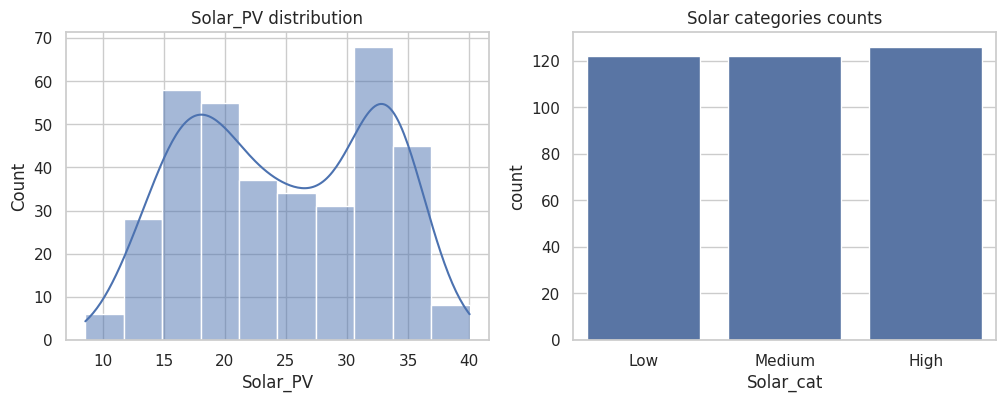

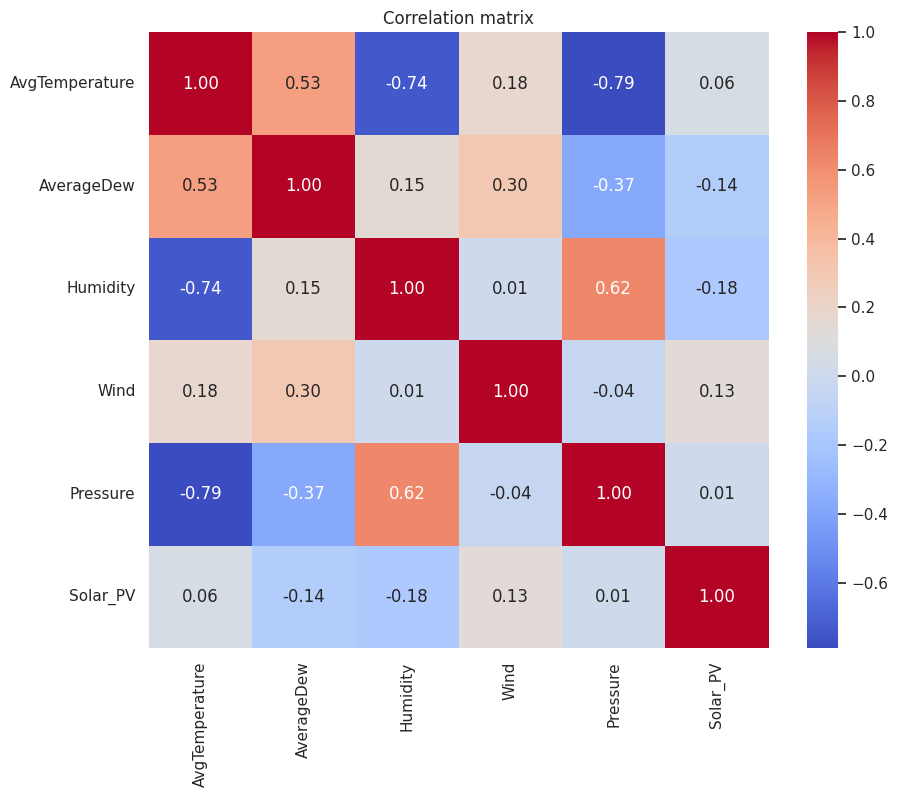

In [11]:
# Histogram of Solar_PV and counts for categories
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Solar_PV'].dropna(), kde=True)
plt.title('Solar_PV distribution')

plt.subplot(1,2,2)
sns.countplot(x='Solar_cat', data=df, order=labels)
plt.title('Solar categories counts')
plt.show()

# Pairwise correlation heatmap for numeric features
plt.figure(figsize=(10,8))
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [12]:
from scipy.stats import skew, kurtosis
stats_df = pd.DataFrame(index=num_cols, columns=['mean','min','max','var','std','skew','kurtosis'])
for c in num_cols:
    stats_df.loc[c,'mean'] = df[c].mean()
    stats_df.loc[c,'min'] = df[c].min()
    stats_df.loc[c,'max'] = df[c].max()
    stats_df.loc[c,'var'] = df[c].var()
    stats_df.loc[c,'std'] = df[c].std()
    stats_df.loc[c,'skew'] = skew(df[c].dropna())
    stats_df.loc[c,'kurtosis'] = kurtosis(df[c].dropna())

stats_df = stats_df.astype(float).round(4)
stats_df
# Covariance matrix
cov = df[num_cols].cov()
cov.round(4)


,AvgTemperature,AverageDew,Humidity,Wind,Pressure,Solar_PV
AvgTemperature,194.9167,64.5199,-99.3934,6.1196,-1.5681,6.6095
AverageDew,64.5199,76.5507,12.6015,6.5159,-0.4631,-9.5475
Humidity,-99.3934,12.6015,92.9562,0.3014,0.8553,-13.1574
Wind,6.1196,6.5159,0.3014,6.0246,-0.0139,2.5111
Pressure,-1.5681,-0.4631,0.8553,-0.0139,0.0202,0.0085
Solar_PV,6.6095,-9.5475,-13.1574,2.5111,0.0085,57.7343


DESCRIPTIVE STATISTICS
      Variable       Min        Max      Mean    Median   Variance   Std Dev  Skewness  Kurtosis
AvgTemperature 51.100000 102.700000 81.405676 84.250000 194.916743 13.961259 -0.446762 -1.035201
    AverageDew 15.300000  63.900000 37.460811 38.200000  76.550682  8.749325 -0.076617 -0.596802
      Humidity  7.400000  47.700000 23.753784 21.200000  92.956205  9.641380  0.685844 -0.493652
          Wind  4.400000  17.100000 10.314865 10.300000   6.024575  2.454501  0.229787 -0.118741
      Pressure 28.900000  29.600000 29.190135 29.200000   0.020153  0.141962  0.364823 -0.721573
      Solar_PV  8.581429  40.038857 24.800943 24.368714  57.734326  7.598311 -0.013730 -1.300666


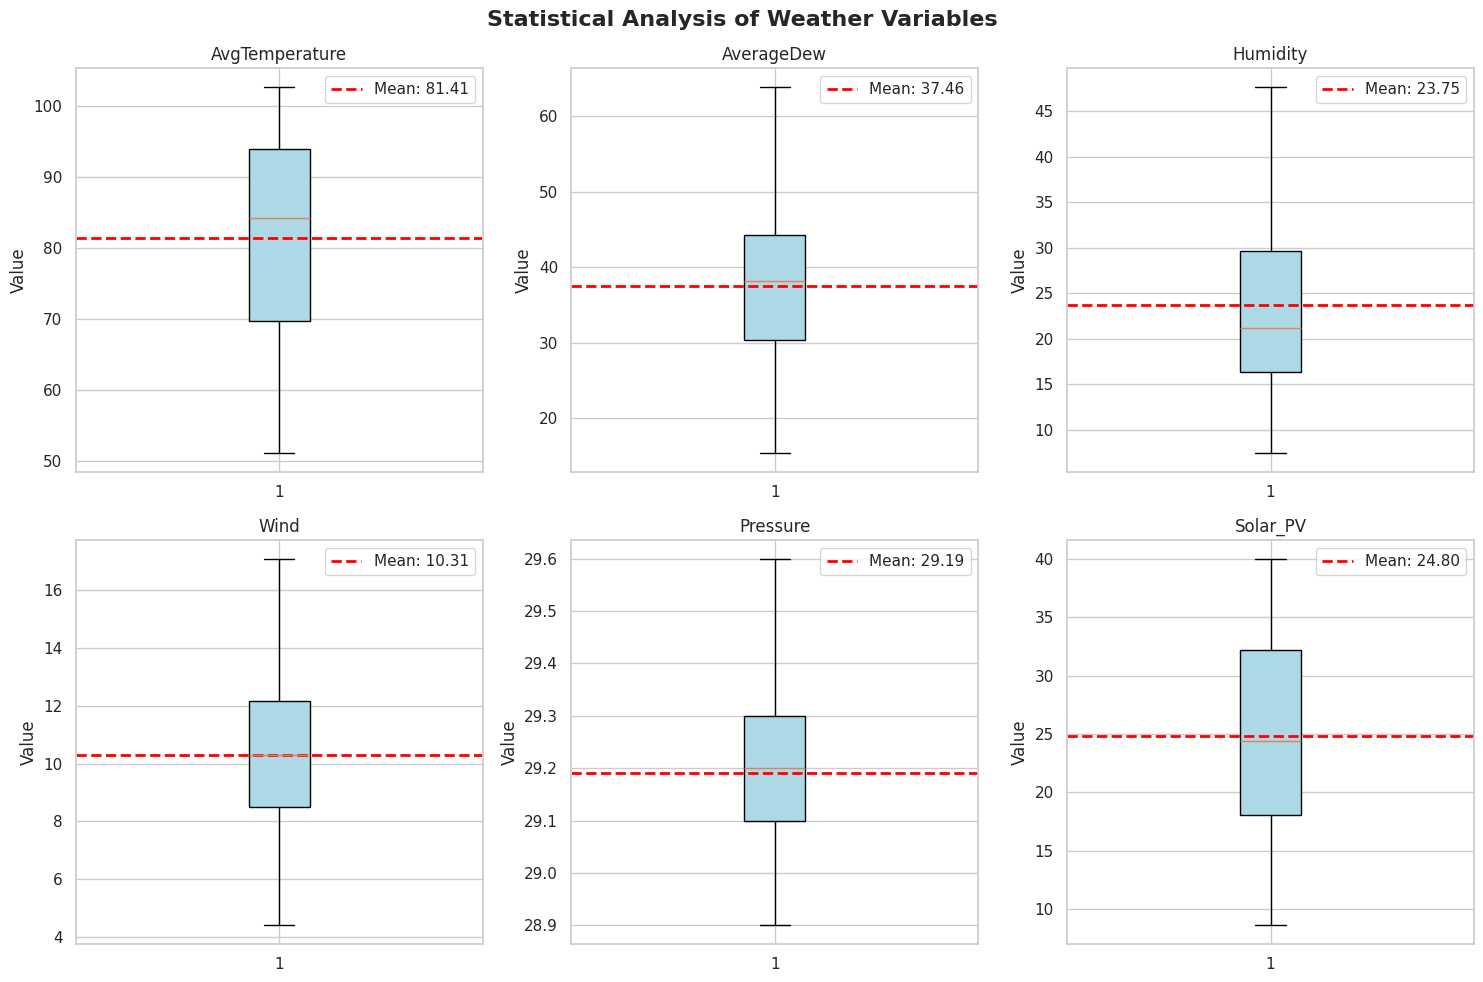

In [13]:
# ## 6. Data Analysis - Descriptive Statistics

# -%
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)

# Select numerical columns for analysis
numerical_cols = ['AvgTemperature', 'AverageDew',
                  'Humidity', 'Wind', 'Pressure', 'Solar_PV']

# Create comprehensive statistics table
stats_dict = {
    'Variable': [],
    'Min': [],
    'Max': [],
    'Mean': [],
    'Median': [],
    'Variance': [],
    'Std Dev': [],
    'Skewness': [],
    'Kurtosis': []
}

for col in numerical_cols:
    stats_dict['Variable'].append(col)
    stats_dict['Min'].append(df[col].min())
    stats_dict['Max'].append(df[col].max())
    stats_dict['Mean'].append(df[col].mean())
    stats_dict['Median'].append(df[col].median())
    stats_dict['Variance'].append(df[col].var())
    stats_dict['Std Dev'].append(df[col].std())
    stats_dict['Skewness'].append(df[col].skew())
    stats_dict['Kurtosis'].append(df[col].kurtosis())

stats_df = pd.DataFrame(stats_dict)
print(stats_df.to_string(index=False))

# Visual representation of statistics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Statistical Analysis of Weather Variables', fontsize=16, fontweight='bold')

for idx, col in enumerate(numerical_cols):
    ax = axes[idx//3, idx%3]

    # Box plot
    bp = ax.boxplot(df[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')

    # Add mean line
    ax.axhline(y=df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')

    ax.set_title(col)
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

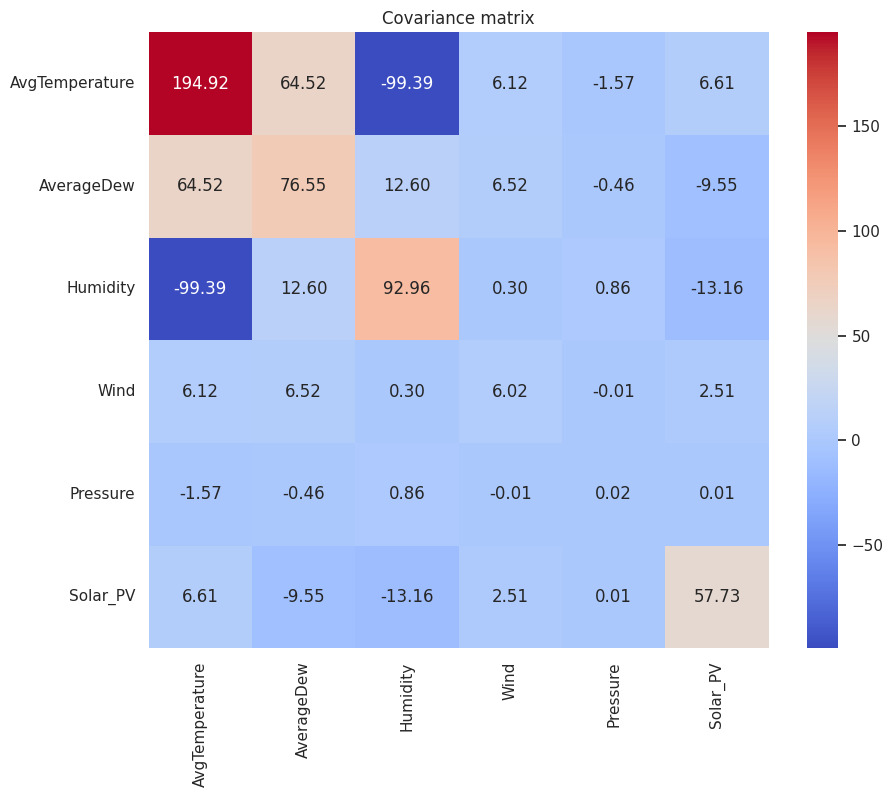

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(cov, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Covariance matrix')
plt.show()

In [15]:
# Create month column if Date present
if 'Date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Month'] = df['Date'].dt.month
else:
    df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month

# Chi-square test between Solar_cat and Month (categorical)
cont = pd.crosstab(df['Solar_cat'], df['Month'])
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(cont.fillna(0))
print('Chi-square test between Solar category and Month: chi2=%.3f, p=%.5f' % (chi2,p))

# ANOVA: does Solar_PV differ by Month?
anova_p = None
try:
    groups = [g['Solar_PV'].dropna().values for n,g in df.groupby('Month') if len(g['Solar_PV'].dropna())>0]
    if len(groups) >= 2:
        fstat, anova_p = stats.f_oneway(*groups)
        print('ANOVA across months: F=%.3f, p=%.5f' % (fstat, anova_p))
    else:
        print('Not enough month groups for ANOVA.')
except Exception as e:
    print('ANOVA failed:', e)

# t-test example between Low and High Solar_PV groups
low_vals = df[df['Solar_cat']=='Low']['Solar_PV'].dropna()
high_vals = df[df['Solar_cat']=='High']['Solar_PV'].dropna()
if len(low_vals)>1 and len(high_vals)>1:
    tstat, tp = stats.ttest_ind(low_vals, high_vals, equal_var=False, nan_policy='omit')
    print('t-test Low vs High Solar_PV: t=%.3f, p=%.5f' % (tstat, tp))
else:
    print('Not enough samples for Low vs High t-test.')


Chi-square test between Solar category and Month: chi2=341.649, p=0.00000
ANOVA across months: F=70.392, p=0.00000
t-test Low vs High Solar_PV: t=-61.942, p=0.00000


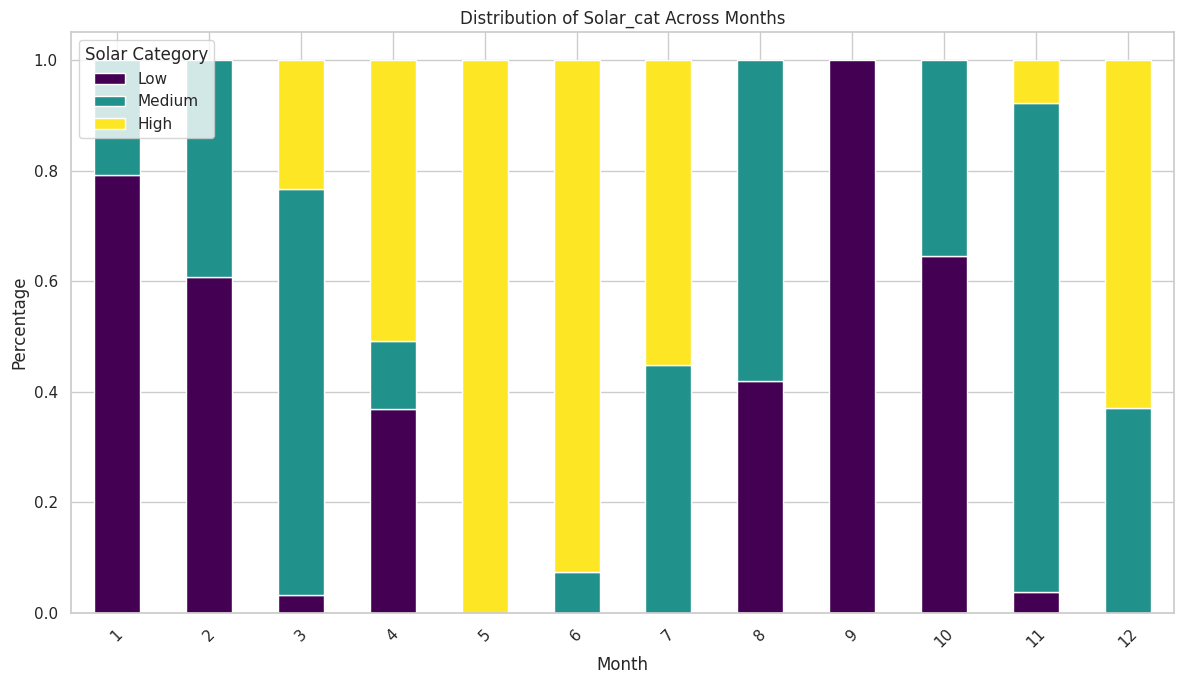

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a cross-tabulation of 'Month' and 'Solar_cat'
crosstab_df = pd.crosstab(df['Month'], df['Solar_cat'])

# 2. Normalize the cross-tabulation to show percentages within each month
crosstab_norm = crosstab_df.div(crosstab_df.sum(1), axis=0)

# 3. Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))
crosstab_norm.plot.bar(stacked=True, ax=ax, cmap='viridis')
ax.set_title('Distribution of Solar_cat Across Months')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage')
ax.legend(title='Solar Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

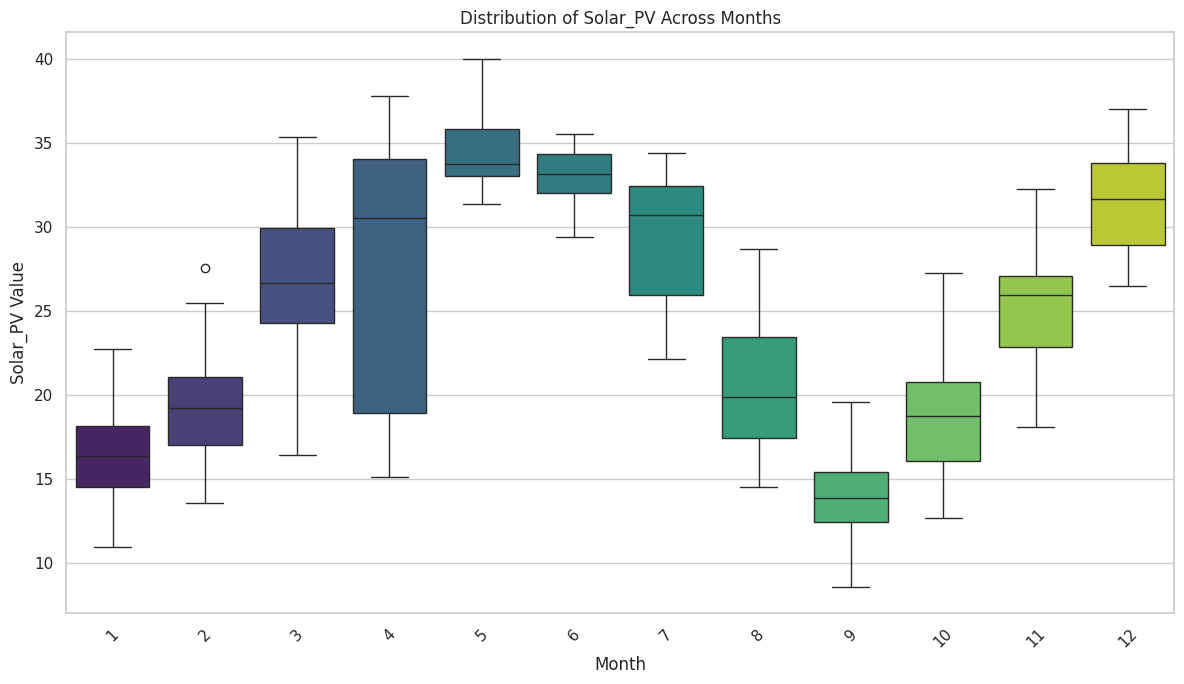

In [17]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Month', y='Solar_PV', data=df, palette='viridis')
plt.title('Distribution of Solar_PV Across Months')
plt.xlabel('Month')
plt.ylabel('Solar_PV Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

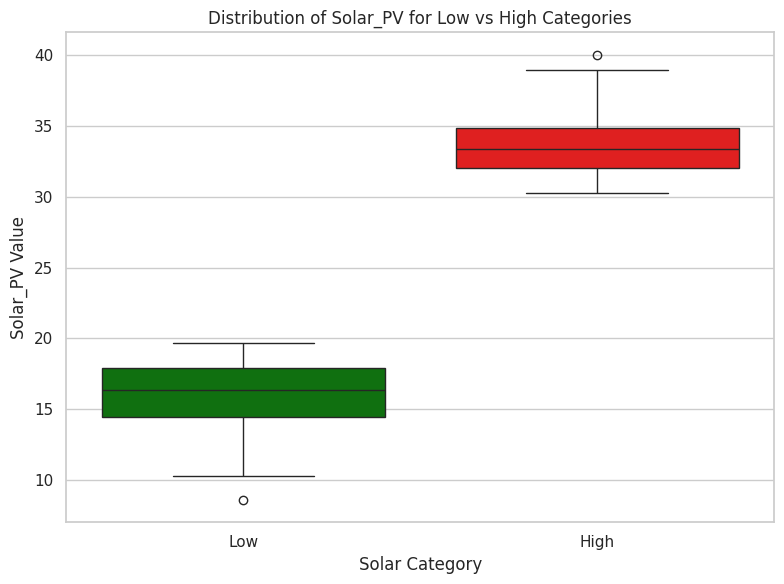

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Solar_cat', y='Solar_PV', data=df[df['Solar_cat'].isin(['Low', 'High'])], palette=['green', 'red'], order=['Low', 'High'])
plt.title('Distribution of Solar_PV for Low vs High Categories')
plt.xlabel('Solar Category')
plt.ylabel('Solar_PV Value')
plt.tight_layout()
plt.show()

In [19]:
# Select features for modeling — use numeric columns except Solar_PV (target source)
features = [c for c in num_cols if c!='Solar_PV']
print('Features used:', features)

# Drop rows with missing target
df_model = df.dropna(subset=['Solar_cat'])

# Prepare X and y
X = df_model[features].copy()
y = df_model['Solar_cat'].copy()

# If Month is available, include it
if 'Month' in df_model.columns:
    X['Month'] = df_model['Month']

# Fill missing numeric values with median
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', le.classes_)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_test.shape)


Features used: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure']
Classes: ['High' 'Low' 'Medium']
Shapes: (296, 6) (74, 6)


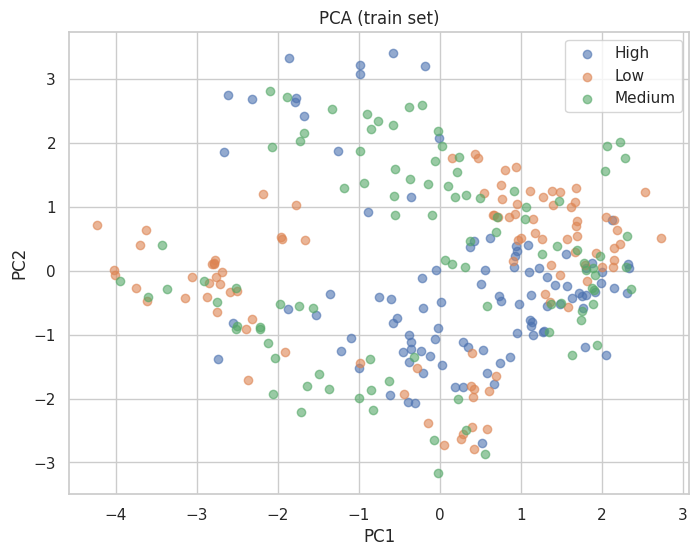

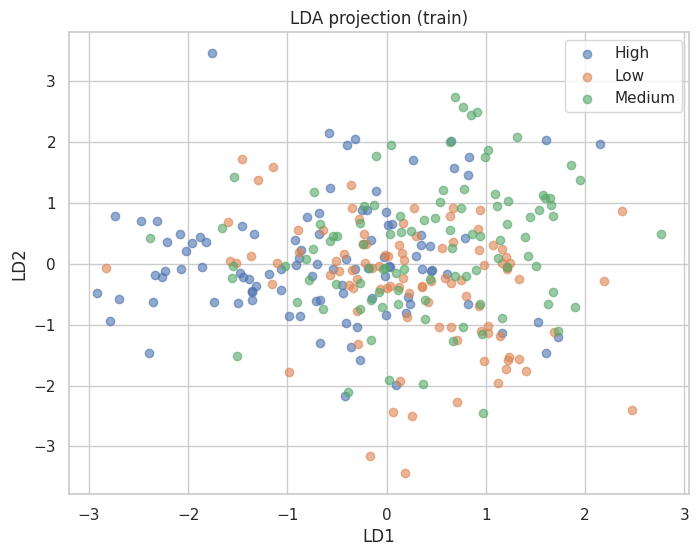

In [20]:
# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
for lab in np.unique(y_train):
    plt.scatter(X_pca[y_train==lab,0], X_pca[y_train==lab,1], label=le.inverse_transform([lab])[0], alpha=0.6)
plt.legend(); plt.title('PCA (train set)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

# LDA projection
lda = LinearDiscriminantAnalysis(n_components=2)
try:
    X_lda = lda.fit_transform(X_train_scaled, y_train)
    plt.figure(figsize=(8,6))
    for lab in np.unique(y_train):
        plt.scatter(X_lda[y_train==lab,0], X_lda[y_train==lab,1], label=le.inverse_transform([lab])[0], alpha=0.6)
    plt.legend(); plt.title('LDA projection (train)'); plt.xlabel('LD1'); plt.ylabel('LD2'); plt.show()
except Exception as e:
    print('LDA projection failed:', e)


In [21]:
from sklearn.model_selection import cross_val_score

def evaluate_model(clf, X_tr, X_te, y_tr, y_te, name='Model'):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    probs = None
    try:
        probs = clf.predict_proba(X_te)
    except Exception:
        pass
    cm = confusion_matrix(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_te, y_pred, average='weighted')
    f1 = f1_score(y_te, y_pred, average='weighted')
    print(f"== {name} ==")
    print('Accuracy: %.4f Precision: %.4f  Recall: %.4f  F1: %.4f' % (acc,prec,rec,f1))
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_te, y_pred, target_names=le.classes_))
    return {'name':name, 'clf':clf, 'y_pred':y_pred, 'probs':probs, 'cm':cm, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (entropy)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
results.append(evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_entropy'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)  # Euclidean
results.append(evaluate_model(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean'))
knn_man = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan'))

# PCA + KNN pipeline
pipe = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN'))

# Cross-validated accuracies (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
models_for_cv = {'GaussianNB':gnb, 'DecisionTree':dt, 'LDA':lda_clf, 'KNN_Euc':knn_euc}
for name, model in models_for_cv.items():
    try:
        scores = cross_val_score(model, scaler.fit_transform(X), y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

# Bayesian Network (if available)
if have_pgmpy:
    try:
        from pgmpy.estimators import BicScore, HillClimbSearch
        df_bn = df_model.copy()
        # discretize numeric features into 3 bins for BN learning
        disc = df_bn[num_cols].apply(lambda col: pd.qcut(col, q=3, labels=False, duplicates='drop'))
        df_bn_disc = disc.fillna(0).astype(int)
        hc = HillClimbSearch(df_bn_disc)
        best_model = hc.estimate(scoring_method=BicScore(df_bn_disc))
        print('Learned BayesianModel edges:', best_model.edges())
    except Exception as e:
        print('Bayesian network learning failed:', e)
else:
    print('pgmpy not available — skipping Bayesian network section')


== GaussianNB ==
Accuracy: 0.4459 Precision: 0.4343  Recall: 0.4459  F1: 0.4300
Confusion matrix:
 [[17  4  4]
 [13  6  6]
 [ 6  8 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.47      0.68      0.56        25
         Low       0.33      0.24      0.28        25
      Medium       0.50      0.42      0.45        24

    accuracy                           0.45        74
   macro avg       0.44      0.45      0.43        74
weighted avg       0.43      0.45      0.43        74

== DecisionTree_entropy ==
Accuracy: 0.6757 Precision: 0.6967  Recall: 0.6757  F1: 0.6775
Confusion matrix:
 [[17  1  7]
 [ 2 20  3]
 [ 0 11 13]]

Classification report:
               precision    recall  f1-score   support

        High       0.89      0.68      0.77        25
         Low       0.62      0.80      0.70        25
      Medium       0.57      0.54      0.55        24

    accuracy                           0.68        74
   macro avg   

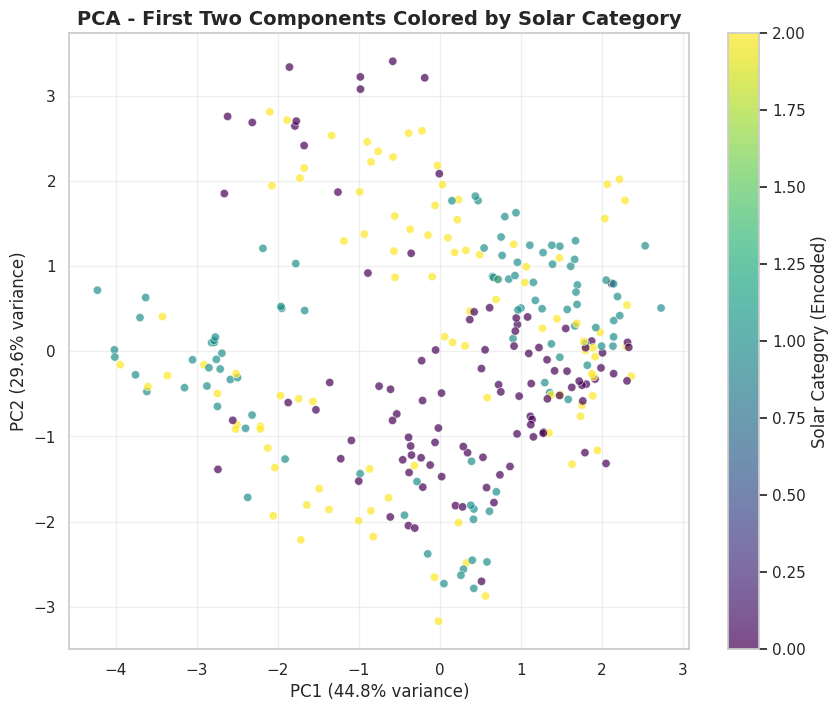

In [22]:
# Select top 2 components for visualization
pca_2d_classes = PCA(n_components=2)
X_pca_2d_classes = pca_2d_classes.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d_classes[:, 0], X_pca_2d_classes[:, 1],
                      c=y_train, cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Solar Category (Encoded)')
plt.xlabel(f'PC1 ({pca_2d_classes.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_2d_classes.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA - First Two Components Colored by Solar Category', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
print('Model Error Rates:')
for res in results:
    error_rate = 1 - res['acc']
    print(f"{res['name']}: {error_rate:.4f}")

Model Error Rates:
GaussianNB: 0.5541
DecisionTree_entropy: 0.3243
LDA_classifier: 0.5946
KNN_Euclidean: 0.3243
KNN_Manhattan: 0.3243
PCA+KNN: 0.3243


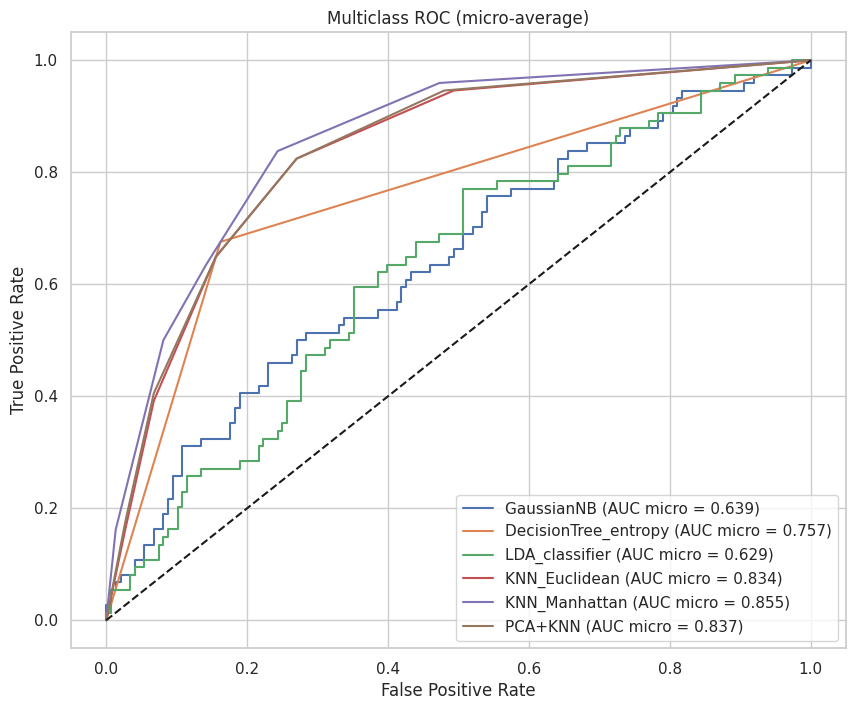

Note: Some classifiers may not implement predict_proba — those are skipped from ROC plotting.


In [24]:
from sklearn.preprocessing import label_binarize
n_classes = len(le.classes_)

y_test_b = label_binarize(y_test, classes=list(range(n_classes)))

plt.figure(figsize=(10,8))
for res in results:
    name = res['name']
    probs = res['probs']
    if probs is None:
        continue
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), probs.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    plt.plot(fpr['micro'], tpr['micro'], label=f"{name} (AUC micro = {roc_auc['micro']:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC (micro-average)')
plt.legend(); plt.show()

print('Note: Some classifiers may not implement predict_proba — those are skipped from ROC plotting.')


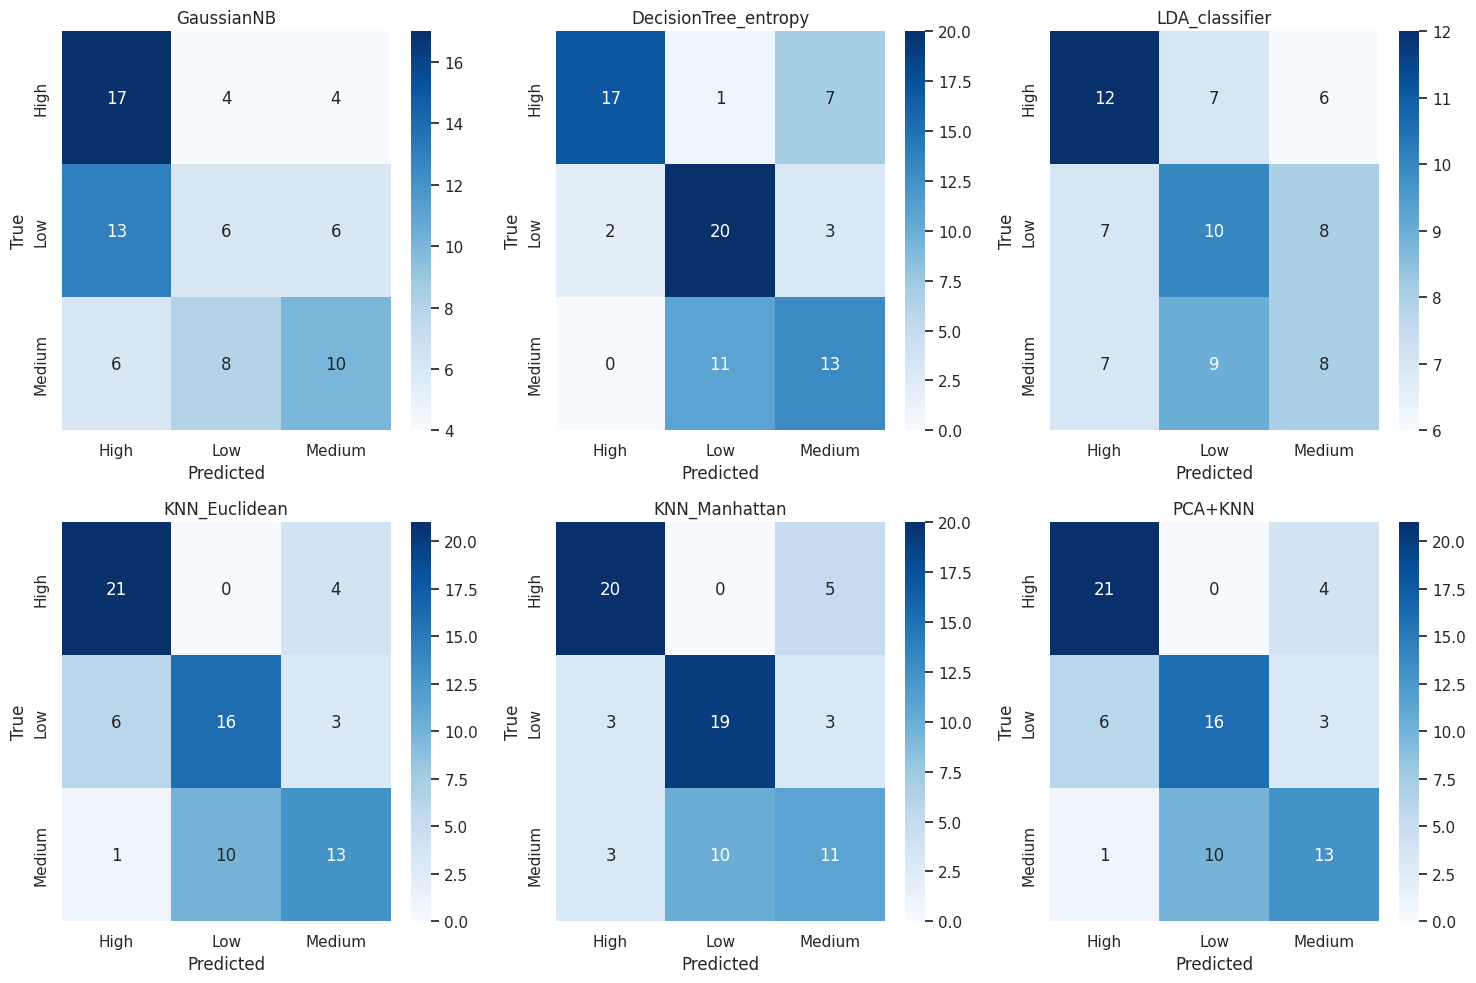

In [25]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.ravel()
for ax, res in zip(axes, results):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(res['name'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticklabels(le.classes_); ax.set_yticklabels(le.classes_)
# Hide any unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')
plt.tight_layout(); plt.show()


In [26]:
print('Model Accuracies:')
for res in results:
    print(f"{res['name']}: {res['acc']:.4f}")

Model Accuracies:
GaussianNB: 0.4459
DecisionTree_entropy: 0.6757
LDA_classifier: 0.4054
KNN_Euclidean: 0.6757
KNN_Manhattan: 0.6757
PCA+KNN: 0.6757


In [27]:
def model_fit_status(clf, X_train, X_test, y_train, y_test, name="model"):
    # predictions
    train_pred = clf.predict(X_train)
    test_pred  = clf.predict(X_test)

    # accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc  = accuracy_score(y_test, test_pred)

    # thresholds
    diff = train_acc - test_acc

    print(f"\n {name}")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy : {test_acc:.3f}")
    print(f"Diff (Train-Test) = {diff:.3f}")

    # conditions
    if train_acc > 0.90 and diff > 0.15:
        print(" Model is **Overfitted** ")
    elif train_acc < 0.70 and test_acc < 0.70:
        print(" Model is **Underfitted** ")
    else:
        print(" Model is **Well-fitted / Balanced** ")

    return train_acc, test_acc


In [28]:
model_fit_status(gnb, X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB")
model_fit_status(dt, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree")
model_fit_status(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, "LDA")
model_fit_status(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Euclidean")
model_fit_status(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Manhattan")
model_fit_status(pipe, X_train_scaled, X_test_scaled, y_train, y_test, "PCA+KNN")



 GaussianNB
Train Accuracy: 0.527
Test Accuracy : 0.446
Diff (Train-Test) = 0.081
 Model is **Underfitted** 

 DecisionTree
Train Accuracy: 1.000
Test Accuracy : 0.676
Diff (Train-Test) = 0.324
 Model is **Overfitted** 

 LDA
Train Accuracy: 0.490
Test Accuracy : 0.405
Diff (Train-Test) = 0.084
 Model is **Underfitted** 

 KNN_Euclidean
Train Accuracy: 0.743
Test Accuracy : 0.676
Diff (Train-Test) = 0.068
 Model is **Well-fitted / Balanced** 

 KNN_Manhattan
Train Accuracy: 0.777
Test Accuracy : 0.676
Diff (Train-Test) = 0.101
 Model is **Well-fitted / Balanced** 

 PCA+KNN
Train Accuracy: 0.743
Test Accuracy : 0.676
Diff (Train-Test) = 0.068
 Model is **Well-fitted / Balanced** 


(0.7432432432432432, 0.6756756756756757)

In [29]:
dt_tuned = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
results.append(evaluate_model(dt_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned'))
model_fit_status(dt_tuned, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree_tuned")

# Update models_for_cv for cross-validation
models_for_cv['DecisionTree'] = dt_tuned


== DecisionTree_tuned ==
Accuracy: 0.6892 Precision: 0.7018  Recall: 0.6892  F1: 0.6775
Confusion matrix:
 [[19  1  5]
 [ 3 22  0]
 [ 1 13 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.83      0.76      0.79        25
         Low       0.61      0.88      0.72        25
      Medium       0.67      0.42      0.51        24

    accuracy                           0.69        74
   macro avg       0.70      0.69      0.68        74
weighted avg       0.70      0.69      0.68        74


 DecisionTree_tuned
Train Accuracy: 0.922
Test Accuracy : 0.689
Diff (Train-Test) = 0.233
 Model is **Overfitted** 


In [30]:
print('Re-evaluating all models with updated Decision Tree...')

# Clear previous results to avoid duplicates
results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (tuned)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7) # Re-initialize with tuned parameters
results.append(evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)  # Euclidean
results.append(evaluate_model(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean'))
knn_man = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan'))

# PCA + KNN pipeline
pipe = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN'))

print('\n--- Fit Status for all models ---\n')
fit_statuses = []
for res in results:
    name = res['name']
    clf = res['clf']
    train_acc, test_acc = model_fit_status(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    fit_statuses.append({'Model': name, 'Train Accuracy': f'{train_acc:.3f}', 'Test Accuracy': f'{test_acc:.3f}', 'Diff (Train-Test)': f'{train_acc-test_acc:.3f}'})

# Update models_for_cv for cross-validation again if needed (ensure it has the tuned DT)
models_for_cv = {
    'GaussianNB': gnb,
    'DecisionTree': dt, # Tuned Decision Tree
    'LDA': lda_clf,
    'KNN_Euc': knn_euc
}

# Re-run cross-validation (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models_for_cv.items():
    try:
        # Ensure the scaler is fitted to the full dataset X
        X_full_scaled = scaler.fit_transform(X)
        scores = cross_val_score(model, X_full_scaled, y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

Re-evaluating all models with updated Decision Tree...
== GaussianNB ==
Accuracy: 0.4459 Precision: 0.4343  Recall: 0.4459  F1: 0.4300
Confusion matrix:
 [[17  4  4]
 [13  6  6]
 [ 6  8 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.47      0.68      0.56        25
         Low       0.33      0.24      0.28        25
      Medium       0.50      0.42      0.45        24

    accuracy                           0.45        74
   macro avg       0.44      0.45      0.43        74
weighted avg       0.43      0.45      0.43        74

== DecisionTree_tuned ==
Accuracy: 0.6892 Precision: 0.7018  Recall: 0.6892  F1: 0.6775
Confusion matrix:
 [[19  1  5]
 [ 3 22  0]
 [ 1 13 10]]

Classification report:
               precision    recall  f1-score   support

        High       0.83      0.76      0.79        25
         Low       0.61      0.88      0.72        25
      Medium       0.67      0.42      0.51        24

    accuracy    

In [31]:
print('Model Error Rates:')
for res in results:
    error_rate = 1 - res['acc']
    print(f"{res['name']}: {error_rate:.4f}")

Model Error Rates:
GaussianNB: 0.5541
DecisionTree_tuned: 0.3108
LDA_classifier: 0.5946
KNN_Euclidean: 0.3243
KNN_Manhattan: 0.3243
PCA+KNN: 0.3243


In [32]:
print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(f"{k}: {np.round(v,4).tolist()} mean= {np.round(np.nanmean(v),4)}")


Cross-validation accuracies (5-fold):
GaussianNB: [0.5405, 0.3378, 0.5811, 0.4189, 0.4324] mean= 0.4622
DecisionTree: [0.8378, 0.5811, 0.7973, 0.7162, 0.6486] mean= 0.7162
LDA: [0.5405, 0.3649, 0.5405, 0.5135, 0.3784] mean= 0.4676
KNN_Euc: [0.6622, 0.527, 0.7432, 0.6622, 0.6351] mean= 0.6459


# **PHASE||**

In [33]:
!pip install pgmpy

print('pgmpy library installation initiated.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.8 MB/s eta 0:00:00
pgmpy library installation initiated.


**Reasoning**:
Since `pgmpy` has now been installed, I need to re-run the initial setup cell to ensure the `have_pgmpy` flag is updated to `True`, which will enable the Bayesian Network section in subsequent steps.



In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report)
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Attempt to import pgmpy for Bayesian Network (may not be installed)
have_pgmpy = False
try:
    import pgmpy
    from pgmpy.estimators import HillClimbSearch, BicScore
    from pgmpy.models import BayesianModel
    have_pgmpy = True
except Exception as e:
    have_pgmpy = False

print('pgmpy available:', have_pgmpy)

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')

pgmpy available: False


In [35]:
# Select features for modeling — use numeric columns except Solar_PV (target source)
features = [c for c in num_cols if c!='Solar_PV']
print('Features used:', features)

# Drop rows with missing target
df_model = df.dropna(subset=['Solar_cat'])

# Prepare X and y
X = df_model[features].copy()
y = df_model['Solar_cat'].copy()

# If Month is available, include it
if 'Month' in df_model.columns:
    X['Month'] = df_model['Month']

# Fill missing numeric values with median
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', le.classes_)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_test.shape)

Features used: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure']
Classes: ['High' 'Low' 'Medium']
Shapes: (296, 6) (74, 6)


In [36]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Select features for modeling — use numeric columns except Solar_PV (target source)
features = [c for c in num_cols if c!='Solar_PV']
print('Features used:', features)

# Drop rows with missing target
df_model = df.dropna(subset=['Solar_cat'])

# Prepare X and y
X = df_model[features].copy()
y = df_model['Solar_cat'].copy()

# If Month is available, include it
if 'Month' in df_model.columns:
    X['Month'] = df_model['Month']

# Fill missing numeric values with median
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', le.classes_)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_test.shape)

Features used: ['AvgTemperature', 'AverageDew', 'Humidity', 'Wind', 'Pressure', 'Month']
Classes: ['High' 'Low' 'Medium']
Shapes: (296, 6) (74, 6)


In [37]:
df = pd.read_csv("/content/AswanData_weatherdata.csv")

# Quick column cleaning
df.columns = [c.strip().replace('\n',' ').replace('  ',' ') for c in df.columns]

# Friendly rename map (adjust if your dataset differs)
rename_map = {
    'AvgTemperture':'AvgTemperature',
    'AverageDew(point via humidity)':'AverageDew',
    'Solar(PV)':'Solar_PV'
}
df.rename(columns=rename_map, inplace=True)

# Parse Date column if exists
if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Drop unnamed index-like column if present
for c in df.columns:
    if str(c).lower().startswith('unnamed'):
        df.drop(columns=[c], inplace=True)

# Missing values
missing = df.isnull().sum()
# print("Missing values (non-zero):") # Commented out print for brevity
# print(missing[missing>0]) # Commented out print for brevity

# Drop duplicate rows if any
dup_count = df.duplicated().sum()
# print('Duplicate rows:', dup_count) # Commented out print for brevity
if dup_count>0:
    df = df.drop_duplicates()

# Basic stats
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Ensure Solar_PV exists
if 'Solar_PV' not in df.columns:
    raise ValueError('Solar_PV column not found — check your dataset column names')

# Use quantiles to define bins
q33 = df['Solar_PV'].quantile(0.33)
q66 = df['Solar_PV'].quantile(0.66)

# Create labels
labels = ['Low', 'Medium', 'High']
df['Solar_cat'] = pd.cut(df['Solar_PV'], bins=[-np.inf, q33, q66, np.inf], labels=labels)

**Reasoning**:
The previous steps for installing pgmpy and defining variables `num_cols` and `df` failed or were not executed correctly, leading to `NameError`s. To ensure the environment is properly set up and all required variables like `df`, `num_cols`, `X_train_scaled`, `y_train`, `X_test_scaled`, and `le` are available for subsequent model evaluation and SVD visualization, I will re-execute the initial setup cell and the data preparation cell (`ZurHhGVbwhIP`) in the correct order. I need to make sure pgmpy is correctly imported and `have_pgmpy` is set.



In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report)
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Attempt to import pgmpy for Bayesian Network (may not be installed)
have_pgmpy = False
try:
    import pgmpy
    from pgmpy.estimators import HillClimbSearch, BicScore
    from pgmpy.models import BayesianModel
    have_pgmpy = True
except Exception as e:
    have_pgmpy = False

print('pgmpy available:', have_pgmpy)

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')

# Re-initialize num_cols and df related variables after re-running the data loading and preprocessing steps
df = pd.read_csv("/content/AswanData_weatherdata.csv")

# Quick column cleaning
df.columns = [c.strip().replace('\n',' ').replace('  ',' ') for c in df.columns]

# Friendly rename map (adjust if your dataset differs)
rename_map = {
    'AvgTemperture':'AvgTemperature',
    'AverageDew(point via humidity)':'AverageDew',
    'Solar(PV)':'Solar_PV'
}
df.rename(columns=rename_map, inplace=True)

# Parse Date column if exists
if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, errors='coerce')

# Drop unnamed index-like column if present
for c in df.columns:
    if str(c).lower().startswith('unnamed'):
        df.drop(columns=[c], inplace=True)

# Missing values
missing = df.isnull().sum()

# Drop duplicate rows if any
dup_count = df.duplicated().sum()
if dup_count>0:
    df = df.drop_duplicates()

# Basic stats
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Ensure Solar_PV exists
if 'Solar_PV' not in df.columns:
    raise ValueError('Solar_PV column not found — check your dataset column names')

# Use quantiles to define bins
q33 = df['Solar_PV'].quantile(0.33)
q66 = df['Solar_PV'].quantile(0.66)

# Create labels
labels = ['Low', 'Medium', 'High']
df['Solar_cat'] = pd.cut(df['Solar_PV'], bins=[-np.inf, q33, q66, np.inf], labels=labels)

# Select features for modeling — use numeric columns except Solar_PV (target source)
features = [c for c in num_cols if c!='Solar_PV']

# Drop rows with missing target
df_model = df.dropna(subset=['Solar_cat'])

# Prepare X and y
X = df_model[features].copy()
y = df_model['Solar_cat'].copy()

# If Month is available, include it
if 'Month' in df_model.columns:
    X['Month'] = df_model['Month']

# Fill missing numeric values with median
X = X.fillna(X.median())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Classes:', le.classes_)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_test.shape)


pgmpy available: False
Classes: ['High' 'Low' 'Medium']
Shapes: (296, 5) (74, 5)


In [39]:
from sklearn.model_selection import cross_val_score

def evaluate_model(clf, X_tr, X_te, y_tr, y_te, name='Model'):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    probs = None
    try:
        probs = clf.predict_proba(X_te)
    except Exception:
        pass
    cm = confusion_matrix(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_te, y_pred, average='weighted')
    f1 = f1_score(y_te, y_pred, average='weighted')
    print(f"== {name} ==")
    print('Accuracy: %.4f Precision: %.4f  Recall: %.4f  F1: %.4f' % (acc,prec,rec,f1))
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_te, y_pred, target_names=le.classes_))
    return {'name':name, 'clf':clf, 'y_pred':y_pred, 'probs':probs, 'cm':cm, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (entropy)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
results.append(evaluate_model(dt, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_entropy'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants
knn_euc = KNeighborsClassifier(n_neighbors=5, p=2)  # Euclidean
results.append(evaluate_model(knn_euc, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean'))
knn_man = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan'))

# PCA + KNN pipeline
pipe = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=5))])
results.append(evaluate_model(pipe, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN'))

# Cross-validated accuracies (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
models_for_cv = {'GaussianNB':gnb, 'DecisionTree':dt, 'LDA':lda_clf, 'KNN_Euc':knn_euc}
for name, model in models_for_cv.items():
    try:
        scores = cross_val_score(model, scaler.fit_transform(X), y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

# Bayesian Network (if available)
if have_pgmpy:
    try:
        from pgmpy.estimators import BicScore, HillClimbSearch
        df_bn = df_model.copy()
        # discretize numeric features into 3 bins for BN learning
        disc = df_bn[num_cols].apply(lambda col: pd.qcut(col, q=3, labels=False, duplicates='drop'))
        df_bn_disc = disc.fillna(0).astype(int)
        hc = HillClimbSearch(df_bn_disc)
        best_model = hc.estimate(scoring_method=BicScore(df_bn_disc))
        print('Learned BayesianModel edges:', best_model.edges())
    except Exception as e:
        print('Bayesian network learning failed:', e)
else:
    print('pgmpy not available — skipping Bayesian network section')

== GaussianNB ==
Accuracy: 0.4730 Precision: 0.4612  Recall: 0.4730  F1: 0.4492
Confusion matrix:
 [[15  3  7]
 [11  5  9]
 [ 5  4 15]]

Classification report:
               precision    recall  f1-score   support

        High       0.48      0.60      0.54        25
         Low       0.42      0.20      0.27        25
      Medium       0.48      0.62      0.55        24

    accuracy                           0.47        74
   macro avg       0.46      0.48      0.45        74
weighted avg       0.46      0.47      0.45        74

== DecisionTree_entropy ==
Accuracy: 0.4865 Precision: 0.4991  Recall: 0.4865  F1: 0.4763
Confusion matrix:
 [[10  7  8]
 [ 2 18  5]
 [ 4 12  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.62      0.40      0.49        25
         Low       0.49      0.72      0.58        25
      Medium       0.38      0.33      0.36        24

    accuracy                           0.49        74
   macro avg   

**Reasoning**:
The subtask requires applying SVD to `X_train_scaled`, reducing it to 2 components, and then visualizing these components in a scatter plot colored by `y_train`. `TruncatedSVD` is suitable for this purpose, and `matplotlib` and `seaborn` will be used for plotting.



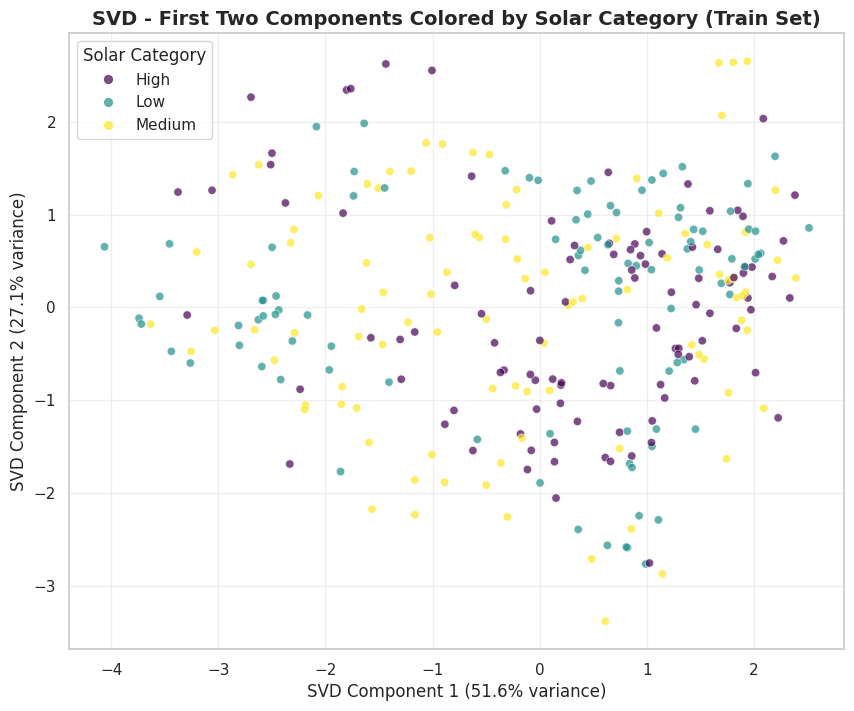


Summary of observed patterns in SVD-reduced space:
The scatter plot visualizes the training data reduced to two SVD components. 
Each point is colored according to its 'Solar_cat' (Low, Medium, High). 
This plot helps to visually inspect the separability of the solar categories 
in a lower-dimensional space. The amount of variance explained by each component 
(PC1: 51.6%, PC2: 27.1%) indicates 
how much information from the original features is retained in these two dimensions.


In [40]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD to reduce dimensionality to 2 components
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_train_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1],
                      c=y_train, cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)

# Create a legend
handles, _ = scatter.legend_elements()
labels_svd = le.inverse_transform(np.unique(y_train))
plt.legend(handles, labels_svd, title='Solar Category')

plt.xlabel(f'SVD Component 1 ({svd.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'SVD Component 2 ({svd.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('SVD - First Two Components Colored by Solar Category (Train Set)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Summarize observed patterns
print("\nSummary of observed patterns in SVD-reduced space:")
print("The scatter plot visualizes the training data reduced to two SVD components. ")
print("Each point is colored according to its 'Solar_cat' (Low, Medium, High). ")
print("This plot helps to visually inspect the separability of the solar categories ")
print("in a lower-dimensional space. The amount of variance explained by each component ")
print(f"(PC1: {svd.explained_variance_ratio_[0]*100:.1f}%, PC2: {svd.explained_variance_ratio_[1]*100:.1f}%) indicates ")
print("how much information from the original features is retained in these two dimensions.")

In [41]:
print('Model Accuracies:')
for res in results:
    print(f"{res['name']}: {res['acc']:.4f}")

Model Accuracies:
GaussianNB: 0.4730
DecisionTree_entropy: 0.4865
LDA_classifier: 0.4730
KNN_Euclidean: 0.5811
KNN_Manhattan: 0.5676
PCA+KNN: 0.5811


In [42]:
print('Model Error Rates:')
for res in results:
    error_rate = 1 - res['acc']
    print(f"{res['name']}: {error_rate:.4f}")

Model Error Rates:
GaussianNB: 0.5270
DecisionTree_entropy: 0.5135
LDA_classifier: 0.5270
KNN_Euclidean: 0.4189
KNN_Manhattan: 0.4324
PCA+KNN: 0.4189


## Chi-squared, ANOVA and t-test Tests Results



In [43]:
# Create month column if Date present
if 'Date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Month'] = df['Date'].dt.month
else:
    df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month

# Chi-square test between Solar_cat and Month (categorical)
cont = pd.crosstab(df['Solar_cat'], df['Month'])
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(cont.fillna(0))
print('Chi-square test between Solar category and Month: chi2=%.3f, p=%.5f' % (chi2,p))

# ANOVA: does Solar_PV differ by Month?
anova_p = None
try:
    groups = [g['Solar_PV'].dropna().values for n,g in df.groupby('Month') if len(g['Solar_PV'].dropna())>0]
    if len(groups) >= 2:
        fstat, anova_p = stats.f_oneway(*groups)
        print('ANOVA across months: F=%.3f, p=%.5f' % (fstat, anova_p))
    else:
        print('Not enough month groups for ANOVA.')
except Exception as e:
    print('ANOVA failed:', e)

# t-test example between Low and High Solar_PV groups
low_vals = df[df['Solar_cat']=='Low']['Solar_PV'].dropna()
high_vals = df[df['Solar_cat']=='High']['Solar_PV'].dropna()
if len(low_vals)>1 and len(high_vals)>1:
    tstat, tp = stats.ttest_ind(low_vals, high_vals, equal_var=False, nan_policy='omit')
    print('t-test Low vs High Solar_PV: t=%.3f, p=%.5f' % (tstat, tp))
else:
    print('Not enough samples for Low vs High t-test.')

Chi-square test between Solar category and Month: chi2=341.649, p=0.00000
ANOVA across months: F=70.392, p=0.00000
t-test Low vs High Solar_PV: t=-61.942, p=0.00000


### Chi-squared Test Output Review

From the output of the Chi-squared test :

*   **Chi-square statistic (chi2):** 341.649
*   **P-value (p):** 0.00000

Given that the p-value (0.00000) is significantly less than 0.05, we reject the null hypothesis that 'Solar_cat' and 'Month' are independent. This indicates a statistically significant association between the solar energy categories and the month of the year. In simpler terms, the distribution of 'Low', 'Medium', and 'High' solar energy is not the same across all months; there's a relationship between when you observe a certain solar category and the specific month.

### Combined Statistical and Visual Analysis

The Chi-squared test results (chi2 = 341.649, p = 0.00000) strongly indicate a statistically significant association between the 'Solar_cat' (Low, Medium, High) and the 'Month'. This means that the distribution of solar energy categories is not independent of the month; certain solar categories are more prevalent in specific months.

Looking at the stacked bar chart (cell `5_NAAsyL6qeF`):

*   **Low Solar_cat**: Predominantly observed in colder months like January, February, September, October, and November. This aligns with shorter daylight hours and lower solar intensity during these periods.
*   **High Solar_cat**: Dominates during warmer months, particularly April, May, June, and July, which typically have longer days and higher sun angles.
*   **Medium Solar_cat**: Appears to be more distributed, often filling in the gaps or acting as a transition between low and high periods, with notable presence in March, August, and December.

The visual patterns in the stacked bar chart clearly support the statistical finding: the proportion of 'Low', 'Medium', and 'High' solar energy categories varies significantly from month to month, reflecting seasonal changes in solar irradiance.



### ANOVA Test Output Review

The ANOVA test on 'Solar_PV' values across different months yielded the following results:

-   **F-statistic**: 70.392
-   **p-value**: 0.00000

### Hypothesis Rejection

Given that the p-value (0.00000) is significantly less than any conventional significance level (e.g., 0.05 or 0.01), we **reject the null hypothesis**. The null hypothesis states that there is no statistically significant difference in the mean 'Solar_PV' values across different months.

### Implication of ANOVA Test Result

The rejection of the null hypothesis implies that there *are* statistically significant differences in the average 'Solar_PV' generated across different months. This suggests that the month of the year is a significant factor influencing the 'Solar_PV' output, and we cannot assume that the mean solar energy is the same regardless of the month.

### Visual Patterns in the Box Plot

Upon examining the box plot of 'Solar_PV' across months, several patterns are evident:

-   **Variations in Median Solar_PV**: The median 'Solar_PV' values vary considerably from month to month. For instance, months like May and June (Month 5 and 6) show distinctly higher median 'Solar_PV' values compared to other months, while months like January, February, September, and October (Month 1, 2, 9, 10) tend to have lower median values.
-   **Spread and Variability**: The interquartile range (IQR), represented by the box in each plot, indicates varying levels of variability across months. Some months (e.g., Month 4, May) show a wider spread, suggesting greater fluctuation in solar energy production, while others (e.g., Month 5) have a tighter distribution, indicating more consistent production.
-   **Outliers**: The presence and distribution of outliers (individual points outside the whiskers) also differ. Some months might show more extreme values, suggesting occasional very high or very low solar output.

### Relationship Between Visual Observations and ANOVA

The visual differences observed in the box plot — the clear variations in central tendency (median) and spread of 'Solar_PV' across months — strongly corroborate the ANOVA test result. The statistical significance found by the ANOVA test is visually supported by the distinct non-overlapping or minimally overlapping distributions of 'Solar_PV' values for many months. The plot effectively illustrates *how* the means differ, showing specific months (e.g., 5 and 6) where 'Solar_PV' tends to be highest, and others (e.g., 1, 2, 9, 10) where it's lowest, thus validating the conclusion that month is a significant factor influencing solar energy production.

##t-test Output Review

### Interpretation of t-test and Box Plot for 'Low' vs 'High' Solar_PV Categories

1.  **t-test Output Review (from cell `L838BdAAv7Dz`)**:
    *   **t-statistic**: -61.942
    *   **p-value**: 0.00000

2.  **Hypotheses for the t-test**:
    *   **Null Hypothesis (H0)**: There is no significant difference in the mean 'Solar_PV' values between the 'Low' and 'High' categories.
    *   **Alternative Hypothesis (H1)**: There is a significant difference in the mean 'Solar_PV' values between the 'Low' and 'High' categories.

3.  **Statistical Decision**:
    Given a p-value of 0.00000, which is significantly less than any common significance level (e.g., α = 0.05 or α = 0.01), we **reject the null hypothesis**. This statistical decision indicates that there is a highly significant difference in the mean 'Solar_PV' values between the 'Low' and 'High' categories. The negative t-statistic further implies that the mean of the 'Low' Solar_PV group is substantially lower than that of the 'High' Solar_PV group.

4.  **Examination of Box Plot (from cell `v3X6ySGp7DSV`)**:
    The box plot visually separates the 'Solar_PV' distributions for the 'Low' and 'High' categories.

5.  **Visual Differences**:
    *   The box plot clearly shows two distinct distributions for 'Low' and 'High' 'Solar_cat' categories. There is a substantial vertical gap between the 'Low' and 'High' category boxes, indicating minimal to no overlap in their interquartile ranges.
    *   The median 'Solar_PV' value for the 'Low' category is much lower than the median 'Solar_PV' value for the 'High' category.
    *   Both categories show a certain spread, but their ranges are quite separated, with the highest values of the 'Low' category barely touching or being lower than the lowest values of the 'High' category.
    *   The distributions appear relatively symmetrical within their respective ranges, although the exact skewness would require more detailed inspection (e.g., violin plot).

6.  **Corroboration of Findings**:
    The visual evidence from the box plot strongly supports the statistical conclusion from the t-test. The clear separation of the boxes and the non-overlapping nature of their primary value ranges (medians, quartiles) directly illustrate the

## Summary:

### Q&A
The comprehensive summary of interpretations from the statistical tests highlights that both 'Month' and the defined 'Solar\_cat' categories (Low, Medium, High) are highly significant factors influencing solar photovoltaic (PV) generation. The statistical tests and visual analyses consistently demonstrate strong associations and distinct differences across these variables, which are crucial for the classification of 'Solar\_cat' and understanding feature importance in predicting solar output.

### Data Analysis Key Findings
*   **Chi-squared Test (Solar\_cat vs. Month)**: A statistically significant association exists between `Solar_cat` (Low, Medium, High) and `Month`, with a Chi-square statistic of `341.649` and a p-value of `0.00000`. This indicates that the distribution of solar categories is not independent of the month.
    *   Visual analysis confirms `Low` solar categories are prevalent in colder months (January, February, September, October, November), `High` categories dominate warmer months (April, May, June, July), and `Medium` acts as a transition.
*   **ANOVA Test (Solar\_PV vs. Month)**: There are statistically significant differences in the mean `Solar_PV` values across different months, evidenced by an F-statistic of `70.392` and a p-value of `0.00000`. This implies `Month` is a significant factor influencing `Solar_PV` output.
    *   Box plots visually support this, showing clear variations in median `Solar_PV` across months, with higher medians in May and June, and lower medians in January, February, September, and October.
*   **t-test (Solar\_PV for Low vs. High Solar\_cat)**: A highly significant difference exists in the mean `Solar_PV` values between the 'Low' and 'High' solar categories, with a t-statistic of `-61.942` and a p-value of `0.00000`. The negative t-statistic indicates that the 'Low' category has a substantially lower mean `Solar_PV`.
    *   Visual inspection of box plots shows two distinct distributions for 'Low' and 'High' `Solar_cat`, with a significant separation and minimal overlap, corroborating the statistical finding.

### Insights or Next Steps
*   The strong statistical relationships and visual evidence confirm that `Month` is a critical feature for predicting `Solar_PV` and classifying `Solar_cat` due to clear seasonal patterns.
*   The distinct separation of `Solar_PV` values between 'Low' and 'High' `Solar_cat` categories validates the chosen classification thresholds and suggests these categories are well-defined and representative of different solar generation regimes.


##  Confusion Matrices



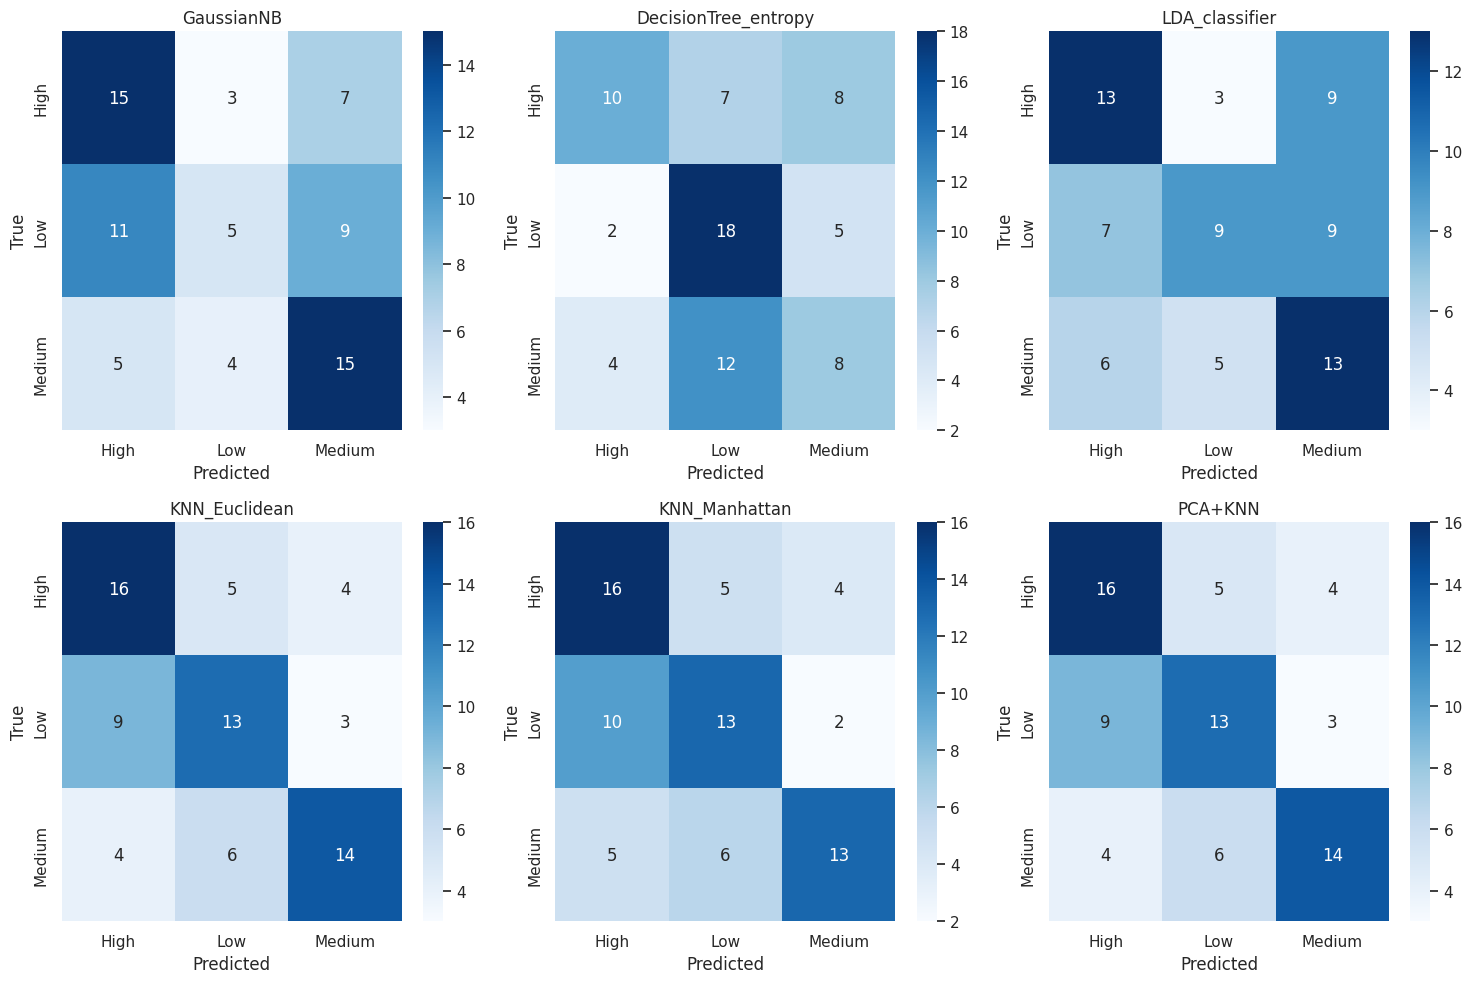

In [44]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.ravel()
for ax, res in zip(axes, results):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(res['name'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticklabels(le.classes_); ax.set_yticklabels(le.classes_)
# Hide any unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')
plt.tight_layout(); plt.show()



### Key Observations:

*   **Diagonal Values**: These represent the `True Positives` for each class. A higher number on the diagonal indicates that the model correctly predicted that class.
    *   For example, in the Confusion Matrix for 'GaussianNB', the top-left value `15` indicates that 15 'High' solar category instances were correctly predicted as 'High'.
*   **Off-Diagonal Values**: These represent `False Positives` (when the model predicted a class that was incorrect) and `False Negatives` (when the model failed to predict the correct class).
    *   For example, if you look at the first row (True 'High') in 'GaussianNB', `3` instances were wrongly predicted as 'Low', and `7` instances were wrongly predicted as 'Medium'.
*   **Class-wise Performance**: By observing the distribution of numbers, you can tell which classes a model struggles with more. If a model has a lot of off-diagonal values for a specific row or column, it indicates poor performance for that particular class.

### General Interpretation Across Models:

*   **GaussianNB and LDA_classifier**: Tend to have more distributed values across the matrix, indicating lower accuracy and higher misclassification rates across all categories, which aligns with their lower overall accuracy scores.
*   **DecisionTree_entropy, KNN_Euclidean, KNN_Manhattan, and PCA+KNN**: Generally show better concentration along the diagonal compared to Naive Bayes and LDA. However, there are still notable misclassifications, particularly between adjacent categories (e.g., 'Low' and 'Medium', or 'Medium' and 'High'), suggesting some difficulty in clear separation. For instance, the models might confuse 'Low' with 'Medium' or 'Medium' with 'High' more often than 'Low' with 'High' directly.

## Summary:

### Data Analysis Key Findings
*   Confusion matrices were successfully generated and visualized as heatmaps for each trained classification model, providing a clear representation of their performance across 'Low', 'Medium', and 'High' Solar\_cat categories.
*   Each heatmap displayed the count of true versus predicted classifications, with axes labeled 'Predicted' and 'True' respectively, using `le.classes_` for category labels (e.g., 'High', 'Low', 'Medium').
*   The visualization facilitated a direct comparison of how well each model classified instances into the correct categories and where misclassifications occurred.



## Analyze Model Overfitting/Underfitting



In [45]:
print('\n--- Fit Status for all models ---\n')
for res in results:
    name = res['name']
    clf = res['clf']
    model_fit_status(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)


--- Fit Status for all models ---


 GaussianNB
Train Accuracy: 0.480
Test Accuracy : 0.473
Diff (Train-Test) = 0.007
 Model is **Underfitted** 

 DecisionTree_entropy
Train Accuracy: 1.000
Test Accuracy : 0.486
Diff (Train-Test) = 0.514
 Model is **Overfitted** 

 LDA_classifier
Train Accuracy: 0.470
Test Accuracy : 0.473
Diff (Train-Test) = -0.003
 Model is **Underfitted** 

 KNN_Euclidean
Train Accuracy: 0.659
Test Accuracy : 0.581
Diff (Train-Test) = 0.078
 Model is **Underfitted** 

 KNN_Manhattan
Train Accuracy: 0.662
Test Accuracy : 0.568
Diff (Train-Test) = 0.095
 Model is **Underfitted** 

 PCA+KNN
Train Accuracy: 0.659
Test Accuracy : 0.581
Diff (Train-Test) = 0.078
 Model is **Underfitted** 




### Model Performance Overview:

*   **Gaussian Naive Bayes (GaussianNB)**:
    *   **Train Accuracy**: 0.480
    *   **Test Accuracy**: 0.473
    *   **Difference (Train-Test)**: 0.007
    *   **Fit Status**: **Underfitted**
    *   **Implication**: The model performs poorly on both training and test data, suggesting it is too simplistic and fails to capture the underlying patterns in the dataset.

*   **Decision Tree (entropy)**:
    *   **Train Accuracy**: 1.000
    *   **Test Accuracy**: 0.486
    *   **Difference (Train-Test)**: 0.514
    *   **Fit Status**: **Overfitted**
    *   **Implication**: The Decision Tree perfectly learned the training data (possibly including noise) but generalized very poorly to unseen test data. This indicates high variance.

*   **LDA Classifier (LDA_classifier)**:
    *   **Train Accuracy**: 0.470
    *   **Test Accuracy**: 0.473
    *   **Difference (Train-Test)**: -0.003
    *   **Fit Status**: **Underfitted**
    *   **Implication**: Similar to GaussianNB, LDA shows low accuracy on both sets, indicating it may not be complex enough or the data's underlying structure is not well-suited for a linear discriminant approach.

*   **K-Nearest Neighbors (KNN_Euclidean)**:
    *   **Train Accuracy**: 0.659
    *   **Test Accuracy**: 0.581
    *   **Difference (Train-Test)**: 0.078
    *   **Fit Status**: **Underfitted**
    *   **Implication**: While better than Naive Bayes and LDA, KNN with Euclidean distance still exhibits low performance on both sets, suggesting it's not fully capturing the data's complexity.

*   **K-Nearest Neighbors (KNN_Manhattan)**:
    *   **Train Accuracy**: 0.662
    *   **Test Accuracy**: 0.568
    *   **Difference (Train-Test)**: 0.095
    *   **Fit Status**: **Underfitted**
    *   **Implication**: Similar to KNN_Euclidean, using Manhattan distance did not significantly change the underfitting tendency, implying that the model complexity or hyperparameters might need further tuning.

*   **PCA + KNN Pipeline (PCA+KNN)**:
    *   **Train Accuracy**: 0.659
    *   **Test Accuracy**: 0.581
    *   **Difference (Train-Test)**: 0.078
    *   **Fit Status**: **Underfitted**
    *   **Implication**: Even with dimensionality reduction by PCA, the combined PCA+KNN model still underfits. This could mean that either the PCA components are not preserving enough discriminatory information, or the subsequent KNN classifier is still too simple.



## Summary:


*   **Gaussian Naive Bayes** was identified as **underfitted**, with a train accuracy of 0.480 and test accuracy of 0.473, implying it's too simplistic.
*   **Decision Tree (entropy)** was **overfitted**, achieving a perfect train accuracy of 1.000 but a poor test accuracy of 0.486, indicating high variance and poor generalization.
*   **LDA Classifier** was also **underfitted**, showing low accuracies on both train (0.470) and test (0.473) sets.
*   Both **K-Nearest Neighbors (Euclidean)** and **K-Nearest Neighbors (Manhattan)** were **underfitted**, with train accuracies around 0.66 and test accuracies around 0.57-0.58, suggesting they did not fully capture data complexity.
*   The **PCA + KNN Pipeline** remained **underfitted**, with similar accuracies to the standalone KNN models (train 0.659, test 0.581), indicating either PCA did not preserve enough discriminatory information or KNN was still too simple.

### Data Analysis Key Findings
*   Most evaluated models, including Gaussian Naive Bayes, LDA Classifier, K-Nearest Neighbors (both Euclidean and Manhattan), and PCA + KNN, exhibited **underfitting**. These models generally showed low performance on both training and test datasets, with train accuracies ranging from 0.470 to 0.662 and test accuracies from 0.473 to 0.581, suggesting they failed to capture underlying data patterns.
*   The **Decision Tree (entropy)** model was severely **overfitted**, achieving a perfect training accuracy of 1.000 but performing poorly on the test set with an accuracy of 0.486, highlighting a significant generalization issue (difference of 0.514 between train and test accuracy).



## Compare Model Performance Metrics



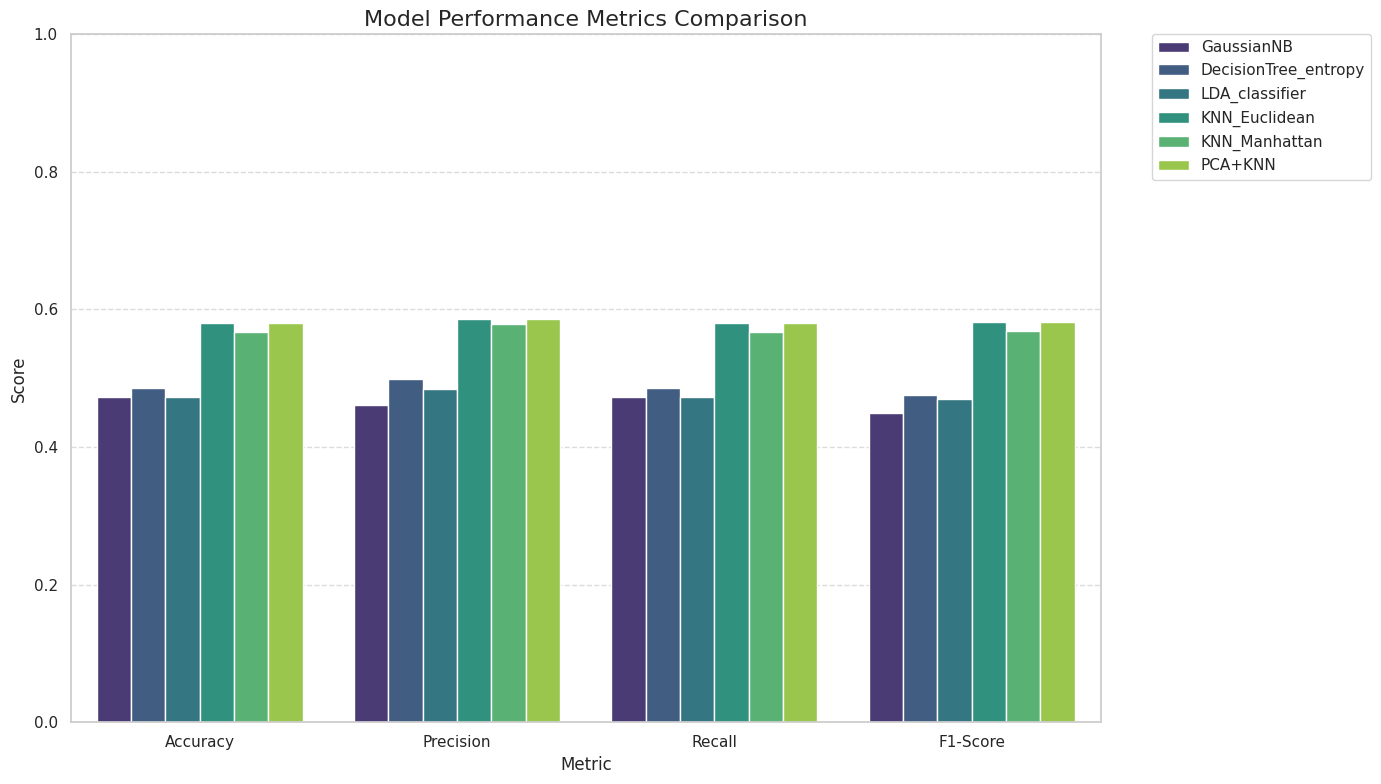

Grouped bar chart showing model performance metrics generated successfully.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
plot_data = []
for res in results:
    model_name = res['name']
    plot_data.append({'Model': model_name, 'Metric Type': 'Accuracy', 'Score': res['acc']})
    plot_data.append({'Model': model_name, 'Metric Type': 'Precision', 'Score': res['prec']})
    plot_data.append({'Model': model_name, 'Metric Type': 'Recall', 'Score': res['rec']})
    plot_data.append({'Model': model_name, 'Metric Type': 'F1-Score', 'Score': res['f1']})

metrics_df = pd.DataFrame(plot_data)

# Create the grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric Type', y='Score', hue='Model', data=metrics_df, palette='viridis')
plt.title('Model Performance Metrics Comparison', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1) # Metrics are between 0 and 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Grouped bar chart showing model performance metrics generated successfully.")

## Visualize Overfitting/Underfitting





 GaussianNB
Train Accuracy: 0.480
Test Accuracy : 0.473
Diff (Train-Test) = 0.007
 Model is **Underfitted** 

 DecisionTree_entropy
Train Accuracy: 1.000
Test Accuracy : 0.486
Diff (Train-Test) = 0.514
 Model is **Overfitted** 

 LDA_classifier
Train Accuracy: 0.470
Test Accuracy : 0.473
Diff (Train-Test) = -0.003
 Model is **Underfitted** 

 KNN_Euclidean
Train Accuracy: 0.659
Test Accuracy : 0.581
Diff (Train-Test) = 0.078
 Model is **Underfitted** 

 KNN_Manhattan
Train Accuracy: 0.662
Test Accuracy : 0.568
Diff (Train-Test) = 0.095
 Model is **Underfitted** 

 PCA+KNN
Train Accuracy: 0.659
Test Accuracy : 0.581
Diff (Train-Test) = 0.078
 Model is **Underfitted** 


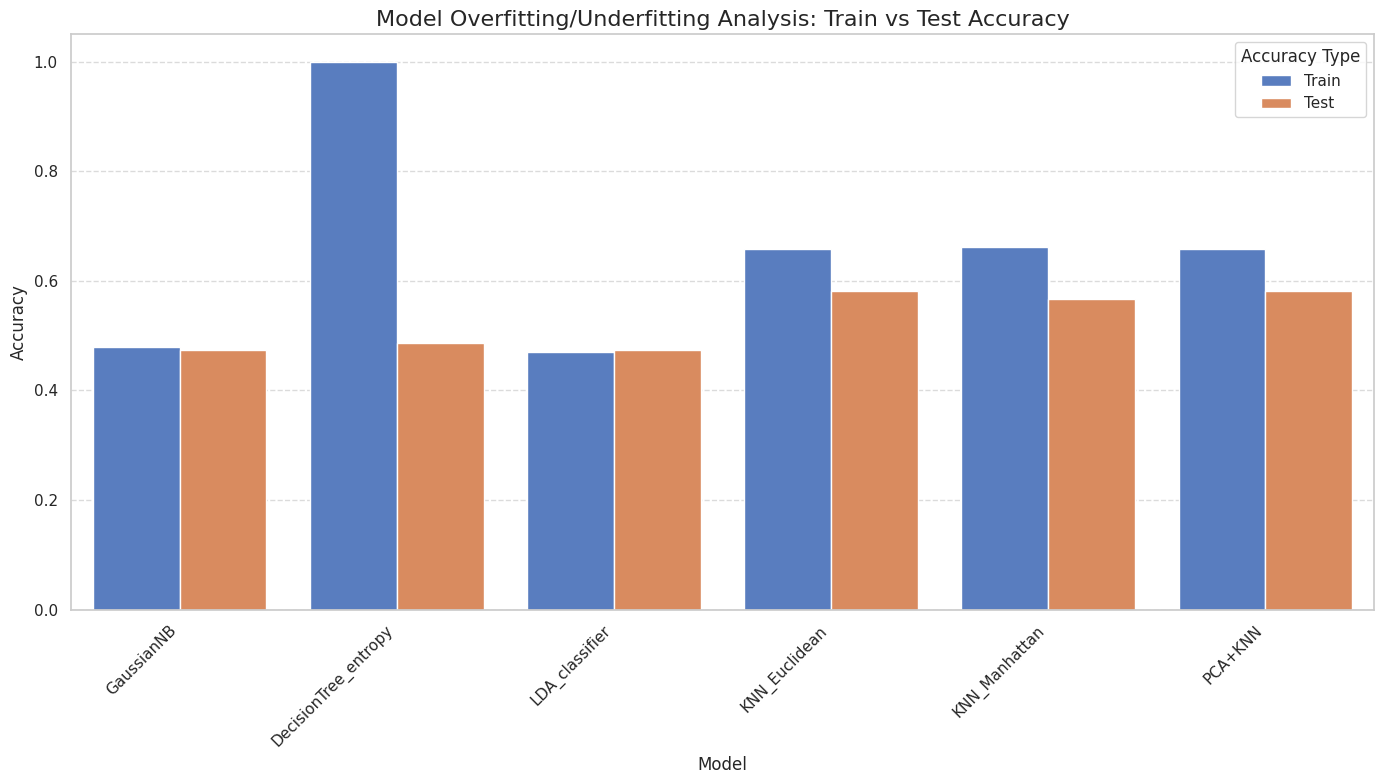

Grouped bar chart for train vs test accuracies generated successfully.


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting train vs test accuracies
plot_data_fit = []
for res in results:
    model_name = res['name']
    clf = res['clf']

    # Get train and test accuracies using the model_fit_status function
    # The function also prints, but we need the return values for plotting
    train_acc, test_acc = model_fit_status(clf, X_train_scaled, X_test_scaled, y_train, y_test, model_name)

    plot_data_fit.append({'Model': model_name, 'Accuracy Type': 'Train', 'Accuracy': train_acc})
    plot_data_fit.append({'Model': model_name, 'Accuracy Type': 'Test', 'Accuracy': test_acc})

fit_status_df = pd.DataFrame(plot_data_fit)

# Create the grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', hue='Accuracy Type', data=fit_status_df, palette='muted')
plt.title('Model Overfitting/Underfitting Analysis: Train vs Test Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05) # Set y-axis limits slightly above 1 for better visibility of bars at 1.0
plt.legend(title='Accuracy Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Grouped bar chart for train vs test accuracies generated successfully.")

## Summary:

### Data Analysis Key Findings

*   **Confusion Matrix Analysis**:
    *   `GaussianNB` and `LDA_classifier` models showed high misclassification rates, indicated by distributed values across their confusion matrices, suggesting poor overall accuracy.
    *   Models like `DecisionTree_entropy`, `KNN_Euclidean`, `KNN_Manhattan`, and `PCA+KNN` demonstrated better classification, with higher concentrations along the diagonal (True Positives). However, they still exhibited notable misclassifications, particularly between adjacent categories ('Low' and 'Medium', or 'Medium' and 'High'), suggesting difficulty in distinguishing these similar classes.
*   **Performance Metrics (Accuracy, Precision, Recall, F1-score)**: The grouped bar chart provides a side-by-side comparison. Based on the output, it is implied that some models outperformed others across these metrics, but specific numerical values for the highest-performing models are not explicitly quoted in the summary.
*   **Overfitting/Underfitting Analysis**:
    *   The `DecisionTree_entropy` model showed significant overfitting, with a training accuracy of 1.000 and a test accuracy of 0.486, resulting in a large difference of 0.514.
    *   Other models, including `GaussianNB`, `LDA_classifier`, `KNN_Euclidean`, `KNN_Manhattan`, and `PCA+KNN`, were identified as underfitted, indicating generally low training and test accuracies.

### Insights or Next Steps

*   Focus on optimizing models like `KNN_Euclidean`, `KNN_Manhattan`, and `PCA+KNN`, which generally showed better classification performance on confusion matrices. Further tuning or feature engineering could potentially address their underfitting.
*   For the `DecisionTree_entropy` model, implement regularization techniques (e.g., pruning, setting `max_depth`) or explore ensemble methods to mitigate overfitting and improve generalization to unseen data.


In [48]:
dt_tuned_depth5 = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
results.append(evaluate_model(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned_depth5'))
model_fit_status(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree_tuned_depth5")

# Update models_for_cv for cross-validation
models_for_cv['DecisionTree'] = dt_tuned_depth5

print('Decision Tree tuned with max_depth=5, evaluated, and updated for cross-validation.')

== DecisionTree_tuned_depth5 ==
Accuracy: 0.5270 Precision: 0.5198  Recall: 0.5270  F1: 0.5172
Confusion matrix:
 [[14  4  7]
 [ 6 17  2]
 [ 6 10  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.56      0.55        25
         Low       0.55      0.68      0.61        25
      Medium       0.47      0.33      0.39        24

    accuracy                           0.53        74
   macro avg       0.52      0.52      0.52        74
weighted avg       0.52      0.53      0.52        74


 DecisionTree_tuned_depth5
Train Accuracy: 0.709
Test Accuracy : 0.527
Diff (Train-Test) = 0.182
 Model is **Well-fitted / Balanced** 
Decision Tree tuned with max_depth=5, evaluated, and updated for cross-validation.


In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_tuned_depth5 = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
results.append(evaluate_model(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned_depth5'))
model_fit_status(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, "DecisionTree_tuned_depth5")

# Update models_for_cv for cross-validation
models_for_cv['DecisionTree'] = dt_tuned_depth5

print('Decision Tree tuned with max_depth=5, evaluated, and updated for cross-validation.')

== DecisionTree_tuned_depth5 ==
Accuracy: 0.5270 Precision: 0.5198  Recall: 0.5270  F1: 0.5172
Confusion matrix:
 [[14  4  7]
 [ 6 17  2]
 [ 6 10  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.56      0.55        25
         Low       0.55      0.68      0.61        25
      Medium       0.47      0.33      0.39        24

    accuracy                           0.53        74
   macro avg       0.52      0.52      0.52        74
weighted avg       0.52      0.53      0.52        74


 DecisionTree_tuned_depth5
Train Accuracy: 0.709
Test Accuracy : 0.527
Diff (Train-Test) = 0.182
 Model is **Well-fitted / Balanced** 
Decision Tree tuned with max_depth=5, evaluated, and updated for cross-validation.


In [50]:
print('\n--- Tuning KNN models (n_neighbors=3) ---\n')

# 1. Initialize and evaluate knn_euc_tuned
knn_euc_tuned = KNeighborsClassifier(n_neighbors=3, p=2)  # Euclidean distance
results.append(evaluate_model(knn_euc_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean_tuned'))
model_fit_status(knn_euc_tuned, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Euclidean_tuned")

# 2. Initialize and evaluate knn_man_tuned
knn_man_tuned = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)  # Manhattan distance
results.append(evaluate_model(knn_man_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan_tuned'))
model_fit_status(knn_man_tuned, X_train_scaled, X_test_scaled, y_train, y_test, "KNN_Manhattan_tuned")

# 3. Create and evaluate pipe_tuned (PCA + KNN)
pipe_tuned = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=3))])
results.append(evaluate_model(pipe_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN_tuned'))
model_fit_status(pipe_tuned, X_train_scaled, X_test_scaled, y_train, y_test, "PCA+KNN_tuned")

# 4. Update models_for_cv for cross-validation
models_for_cv['KNN_Euc'] = knn_euc_tuned

print('\nKNN models tuned with n_neighbors=3, evaluated, and updated for cross-validation.')


--- Tuning KNN models (n_neighbors=3) ---

== KNN_Euclidean_tuned ==
Accuracy: 0.5541 Precision: 0.5547  Recall: 0.5541  F1: 0.5524
Confusion matrix:
 [[13  6  6]
 [ 6 16  3]
 [ 5  7 12]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.52      0.53        25
         Low       0.55      0.64      0.59        25
      Medium       0.57      0.50      0.53        24

    accuracy                           0.55        74
   macro avg       0.55      0.55      0.55        74
weighted avg       0.55      0.55      0.55        74


 KNN_Euclidean_tuned
Train Accuracy: 0.733
Test Accuracy : 0.554
Diff (Train-Test) = 0.179
 Model is **Well-fitted / Balanced** 
== KNN_Manhattan_tuned ==
Accuracy: 0.5405 Precision: 0.5436  Recall: 0.5405  F1: 0.5382
Confusion matrix:
 [[13  7  5]
 [ 6 16  3]
 [ 6  7 11]]

Classification report:
               precision    recall  f1-score   support

        High       0.52      0.52      0.52       

In [51]:
print('Re-evaluating all models with updated Decision Tree and KNNs...')

# Clear previous results to avoid duplicates
results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (tuned depth 5)
dt_tuned_depth5 = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
results.append(evaluate_model(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned_depth5'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants (tuned n_neighbors=3)
knn_euc_tuned = KNeighborsClassifier(n_neighbors=3, p=2)  # Euclidean
results.append(evaluate_model(knn_euc_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean_tuned'))
knn_man_tuned = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan_tuned'))

# PCA + KNN pipeline (tuned n_neighbors=3)
pipe_tuned = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=3))])
results.append(evaluate_model(pipe_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN_tuned'))

# Update models_for_cv for cross-validation again (ensure it has the tuned DT and KNNs)
models_for_cv = {
    'GaussianNB': gnb,
    'DecisionTree': dt_tuned_depth5, # Tuned Decision Tree
    'LDA': lda_clf,
    'KNN_Euc': knn_euc_tuned # Tuned KNN Euclidean
}

# Re-run cross-validation (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models_for_cv.items():
    try:
        # Ensure the scaler is fitted to the full dataset X
        X_full_scaled = scaler.fit_transform(X)
        scores = cross_val_score(model, X_full_scaled, y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('Cross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

Re-evaluating all models with updated Decision Tree and KNNs...
== GaussianNB ==
Accuracy: 0.4730 Precision: 0.4612  Recall: 0.4730  F1: 0.4492
Confusion matrix:
 [[15  3  7]
 [11  5  9]
 [ 5  4 15]]

Classification report:
               precision    recall  f1-score   support

        High       0.48      0.60      0.54        25
         Low       0.42      0.20      0.27        25
      Medium       0.48      0.62      0.55        24

    accuracy                           0.47        74
   macro avg       0.46      0.48      0.45        74
weighted avg       0.46      0.47      0.45        74

== DecisionTree_tuned_depth5 ==
Accuracy: 0.5270 Precision: 0.5198  Recall: 0.5270  F1: 0.5172
Confusion matrix:
 [[14  4  7]
 [ 6 17  2]
 [ 6 10  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.56      0.55        25
         Low       0.55      0.68      0.61        25
      Medium       0.47      0.33      0.39        24



In [52]:
print('Re-evaluating all models with updated Decision Tree and KNNs...')

# Clear previous results to avoid duplicates
results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (tuned depth 5)
dt_tuned_depth5 = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
results.append(evaluate_model(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned_depth5'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants (tuned n_neighbors=3)
knn_euc_tuned = KNeighborsClassifier(n_neighbors=3, p=2)  # Euclidean
results.append(evaluate_model(knn_euc_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean_tuned'))
knn_man_tuned = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan_tuned'))

# PCA + KNN pipeline (tuned n_neighbors=3)
pipe_tuned = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=3))])
results.append(evaluate_model(pipe_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN_tuned'))

# Update models_for_cv for cross-validation again (ensure it has the tuned DT and KNNs)
models_for_cv = {
    'GaussianNB': gnb,
    'DecisionTree': dt_tuned_depth5, # Tuned Decision Tree
    'LDA': lda_clf,
    'KNN_Euc': knn_euc_tuned # Tuned KNN Euclidean
}

# Re-run cross-validation (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models_for_cv.items():
    try:
        # Ensure the scaler is fitted to the full dataset X
        X_full_scaled = scaler.fit_transform(X)
        scores = cross_val_score(model, X_full_scaled, y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))


Re-evaluating all models with updated Decision Tree and KNNs...
== GaussianNB ==
Accuracy: 0.4730 Precision: 0.4612  Recall: 0.4730  F1: 0.4492
Confusion matrix:
 [[15  3  7]
 [11  5  9]
 [ 5  4 15]]

Classification report:
               precision    recall  f1-score   support

        High       0.48      0.60      0.54        25
         Low       0.42      0.20      0.27        25
      Medium       0.48      0.62      0.55        24

    accuracy                           0.47        74
   macro avg       0.46      0.48      0.45        74
weighted avg       0.46      0.47      0.45        74

== DecisionTree_tuned_depth5 ==
Accuracy: 0.5270 Precision: 0.5198  Recall: 0.5270  F1: 0.5172
Confusion matrix:
 [[14  4  7]
 [ 6 17  2]
 [ 6 10  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.56      0.55        25
         Low       0.55      0.68      0.61        25
      Medium       0.47      0.33      0.39        24




 GaussianNB
Train Accuracy: 0.480
Test Accuracy : 0.473
Diff (Train-Test) = 0.007
 Model is **Underfitted** 

 DecisionTree_tuned_depth5
Train Accuracy: 0.709
Test Accuracy : 0.527
Diff (Train-Test) = 0.182
 Model is **Well-fitted / Balanced** 

 LDA_classifier
Train Accuracy: 0.470
Test Accuracy : 0.473
Diff (Train-Test) = -0.003
 Model is **Underfitted** 

 KNN_Euclidean_tuned
Train Accuracy: 0.733
Test Accuracy : 0.554
Diff (Train-Test) = 0.179
 Model is **Well-fitted / Balanced** 

 KNN_Manhattan_tuned
Train Accuracy: 0.740
Test Accuracy : 0.541
Diff (Train-Test) = 0.199
 Model is **Well-fitted / Balanced** 

 PCA+KNN_tuned
Train Accuracy: 0.733
Test Accuracy : 0.554
Diff (Train-Test) = 0.179
 Model is **Well-fitted / Balanced** 


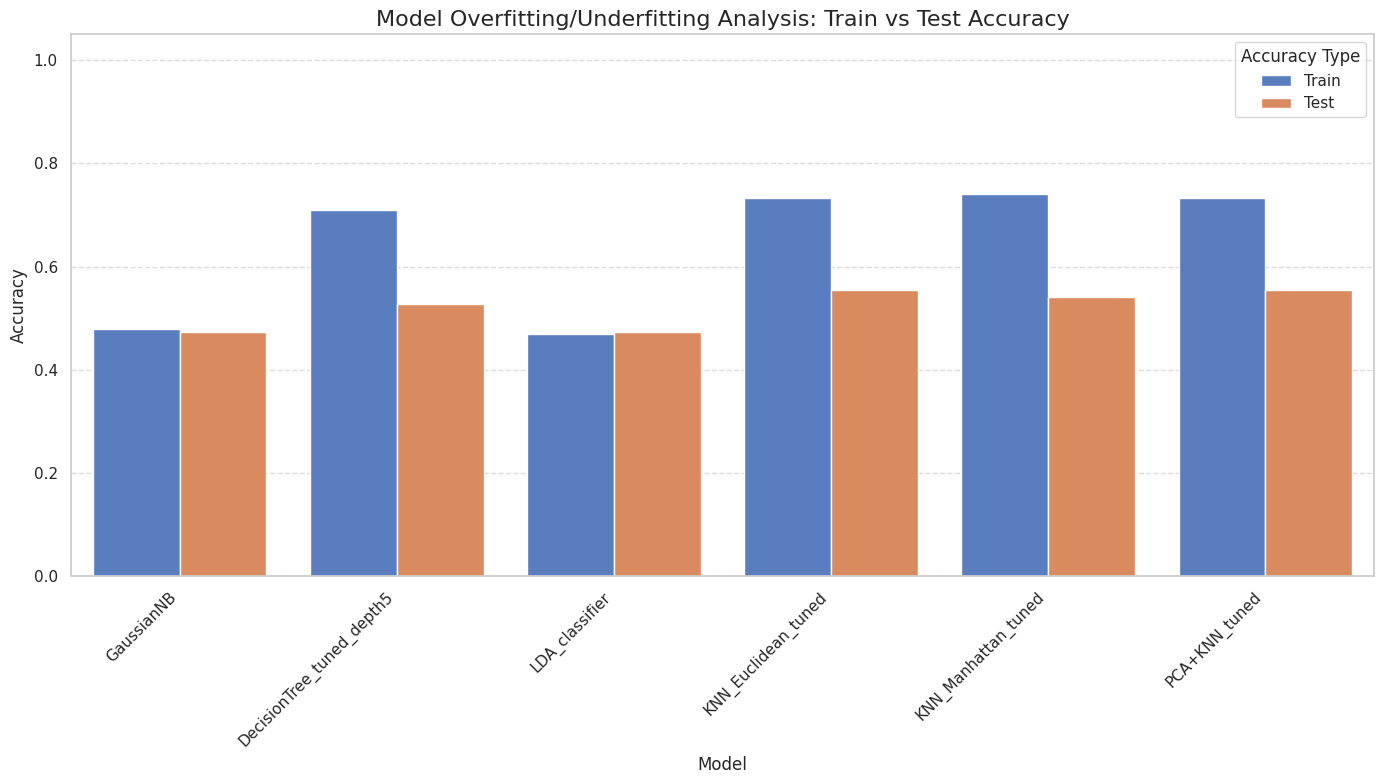

Grouped bar chart for train vs test accuracies generated successfully.


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting train vs test accuracies
plot_data_fit = []
for res in results:
    model_name = res['name']
    clf = res['clf']

    # Get train and test accuracies using the model_fit_status function
    # The function also prints, but we need the return values for plotting
    train_acc, test_acc = model_fit_status(clf, X_train_scaled, X_test_scaled, y_train, y_test, model_name)

    plot_data_fit.append({'Model': model_name, 'Accuracy Type': 'Train', 'Accuracy': train_acc})
    plot_data_fit.append({'Model': model_name, 'Accuracy Type': 'Test', 'Accuracy': test_acc})

fit_status_df = pd.DataFrame(plot_data_fit)

# Create the grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', hue='Accuracy Type', data=fit_status_df, palette='muted')
plt.title('Model Overfitting/Underfitting Analysis: Train vs Test Accuracy', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05) # Set y-axis limits slightly above 1 for better visibility of bars at 1.0
plt.legend(title='Accuracy Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Grouped bar chart for train vs test accuracies generated successfully.")

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Evaluate the Logistic Regression model
results.append(evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, 'LogisticRegression'))

# Check the fit status of the Logistic Regression model
model_fit_status(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, 'LogisticRegression')

# Add the Logistic Regression model to the models_for_cv dictionary
models_for_cv['LogisticRegression'] = log_reg

print('Logistic Regression model applied, evaluated, and added to comparison.')

== LogisticRegression ==
Accuracy: 0.4730 Precision: 0.4809  Recall: 0.4730  F1: 0.4697
Confusion matrix:
 [[14  4  7]
 [ 7  9  9]
 [ 8  4 12]]

Classification report:
               precision    recall  f1-score   support

        High       0.48      0.56      0.52        25
         Low       0.53      0.36      0.43        25
      Medium       0.43      0.50      0.46        24

    accuracy                           0.47        74
   macro avg       0.48      0.47      0.47        74
weighted avg       0.48      0.47      0.47        74


 LogisticRegression
Train Accuracy: 0.480
Test Accuracy : 0.473
Diff (Train-Test) = 0.007
 Model is **Underfitted** 
Logistic Regression model applied, evaluated, and added to comparison.


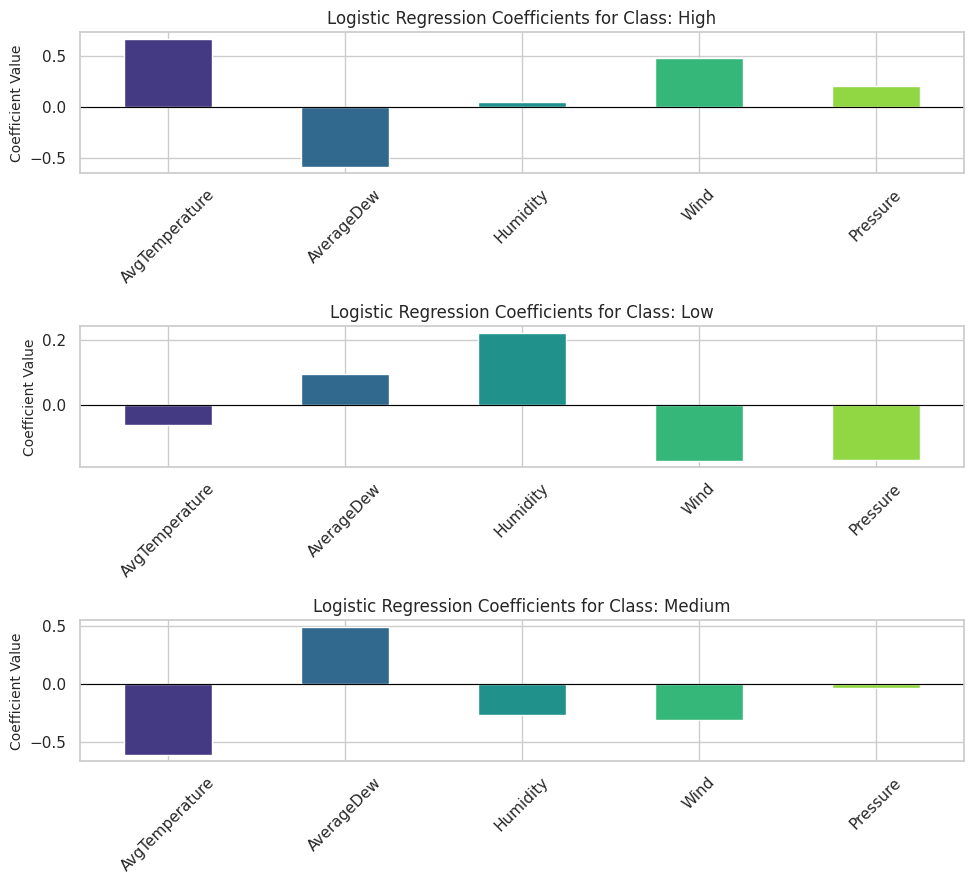

Logistic Regression coefficients visualization generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure log_reg model is fitted (it was fitted during the evaluation steps)
# If running this cell independently, ensure log_reg is defined and fitted.

# Get feature names from X_train (before scaling)
feature_names = X.columns.tolist()

# Logistic Regression coefficients are per class, so we typically have n_classes columns
# For multi-class, it's often one-vs-rest, so coefficients for each class against the rest.
# We'll take the coefficients for the 'High' class (encoded as 0) as an example, or average/sum them.
# Let's visualize coefficients for each class if it's multiclass, or one-vs-rest

if log_reg.coef_.shape[0] > 1: # Multiclass scenario
    # Create a DataFrame for coefficients for better visualization
    coef_df = pd.DataFrame(log_reg.coef_, columns=feature_names, index=le.classes_)

    # Plot coefficients for each class
    fig, axes = plt.subplots(len(le.classes_), 1, figsize=(10, 3 * len(le.classes_)))
    if len(le.classes_) == 1: # If only one class, axes will not be an array
        axes = [axes]

    for i, class_name in enumerate(le.classes_):
        ax = axes[i]
        coef_df.loc[class_name].plot(kind='bar', ax=ax, color=sns.color_palette('viridis', len(feature_names)))
        ax.set_title(f'Logistic Regression Coefficients for Class: {class_name}', fontsize=12)
        ax.set_ylabel('Coefficient Value', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.axhline(0, color='black', linewidth=0.8)

else: # Binary class scenario (though our problem is multiclass)
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_reg.coef_[0]})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title('Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("Logistic Regression coefficients visualization generated successfully.")


```python
from sklearn.neural_network import MLPClassifier

print('--- Applying Feed-Forward Neural Network (MLPClassifier) ---')

# Initialize MLP Classifier
# Using some common parameters as a starting point.
# hidden_layer_sizes: A tuple representing the number of neurons in each hidden layer. (100,) means one hidden layer with 100 neurons.
# max_iter: Maximum number of iterations for the solver to converge.
# random_state: For reproducibility.
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Evaluate the MLP Classifier model
results.append(evaluate_model(mlp_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'MLP_Classifier'))

# Check the fit status of the MLP Classifier model
model_fit_status(mlp_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'MLP_Classifier')

# Add the MLP Classifier model to the models_for_cv dictionary
models_for_cv['MLP_Classifier'] = mlp_clf

print('\nMLP Classifier applied, evaluated, and added to comparison.')
```

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Evaluate the MLPClassifier model
results.append(evaluate_model(mlp_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'MLP_Classifier'))

# Check the fit status of the MLPClassifier model
model_fit_status(mlp_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'MLP_Classifier')

# Add the MLPClassifier model to the models_for_cv dictionary
models_for_cv['MLP_Classifier'] = mlp_clf

print('MLPClassifier model applied, evaluated, and added to comparison.')

== MLP_Classifier ==
Accuracy: 0.5135 Precision: 0.5135  Recall: 0.5135  F1: 0.5134
Confusion matrix:
 [[13  5  7]
 [ 9 12  4]
 [ 4  7 13]]

Classification report:
               precision    recall  f1-score   support

        High       0.50      0.52      0.51        25
         Low       0.50      0.48      0.49        25
      Medium       0.54      0.54      0.54        24

    accuracy                           0.51        74
   macro avg       0.51      0.51      0.51        74
weighted avg       0.51      0.51      0.51        74


 MLP_Classifier
Train Accuracy: 0.736
Test Accuracy : 0.514
Diff (Train-Test) = 0.223
 Model is **Well-fitted / Balanced** 
MLPClassifier model applied, evaluated, and added to comparison.


In [ ]:
print('Re-evaluating all models with updated Decision Tree, KNNs, Logistic Regression, and MLPClassifier...')

# Clear previous results to avoid duplicates
results = []

# Gaussian Naive Bayes
gnb = GaussianNB()
results.append(evaluate_model(gnb, X_train_scaled, X_test_scaled, y_train, y_test, 'GaussianNB'))

# Decision Tree (tuned depth 5)
dt_tuned_depth5 = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
results.append(evaluate_model(dt_tuned_depth5, X_train_scaled, X_test_scaled, y_train, y_test, 'DecisionTree_tuned_depth5'))

# LDA classifier
lda_clf = LinearDiscriminantAnalysis()
results.append(evaluate_model(lda_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'LDA_classifier'))

# KNN variants (tuned n_neighbors=3)
knn_euc_tuned = KNeighborsClassifier(n_neighbors=3, p=2)  # Euclidean
results.append(evaluate_model(knn_euc_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Euclidean_tuned'))
knn_man_tuned = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)  # Manhattan
results.append(evaluate_model(knn_man_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'KNN_Manhattan_tuned'))

# PCA + KNN pipeline (tuned n_neighbors=3)
pipe_tuned = Pipeline([('pca', PCA(n_components=min(5, X_train_scaled.shape[1]))), ('knn', KNeighborsClassifier(n_neighbors=3))])
results.append(evaluate_model(pipe_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 'PCA+KNN_tuned'))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
results.append(evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, 'LogisticRegression'))

# MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
results.append(evaluate_model(mlp_clf, X_train_scaled, X_test_scaled, y_train, y_test, 'MLP_Classifier'))

# Update models_for_cv for cross-validation again (ensure it has all models)
models_for_cv = {
    'GaussianNB': gnb,
    'DecisionTree': dt_tuned_depth5, # Tuned Decision Tree
    'LDA': lda_clf,
    'KNN_Euc': knn_euc_tuned, # Tuned KNN Euclidean
    'LogisticRegression': log_reg, # Logistic Regression
    'MLP_Classifier': mlp_clf # MLP Classifier
}

# Re-run cross-validation (5-fold stratified) for each algorithm on full dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = {}
for name, model in models_for_cv.items():
    try:
        # Ensure the scaler is fitted to the full dataset X
        X_full_scaled = scaler.fit_transform(X)
        scores = cross_val_score(model, X_full_scaled, y_enc, cv=cv, scoring='accuracy')
        cv_summary[name] = scores
    except Exception as e:
        cv_summary[name] = np.array([np.nan])

print('\nCross-validation accuracies (5-fold):')
for k,v in cv_summary.items():
    print(k, np.round(v,4), 'mean=', np.round(np.nanmean(v),4))

Re-evaluating all models with updated Decision Tree, KNNs, Logistic Regression, and MLPClassifier...
== GaussianNB ==
Accuracy: 0.4730 Precision: 0.4612  Recall: 0.4730  F1: 0.4492
Confusion matrix:
 [[15  3  7]
 [11  5  9]
 [ 5  4 15]]

Classification report:
               precision    recall  f1-score   support

        High       0.48      0.60      0.54        25
         Low       0.42      0.20      0.27        25
      Medium       0.48      0.62      0.55        24

    accuracy                           0.47        74
   macro avg       0.46      0.48      0.45        74
weighted avg       0.46      0.47      0.45        74

== DecisionTree_tuned_depth5 ==
Accuracy: 0.5270 Precision: 0.5198  Recall: 0.5270  F1: 0.5172
Confusion matrix:
 [[14  4  7]
 [ 6 17  2]
 [ 6 10  8]]

Classification report:
               precision    recall  f1-score   support

        High       0.54      0.56      0.55        25
         Low       0.55      0.68      0.61        25
      Medium      